## Text Summarization using Amazon Fine Food Reviews Dataset

#### Importing the Libraries

In [ ]:
!pip install elasticsearch
!pip install faiss_gpu
!pip install nlp
!pip install transformers
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.7.1-linux-x86_64.tar.gz
!tar -xzvf elasticsearch-7.7.1-linux-x86_64.tar.gz
!pip install datasets
!pip install apache_beam
!pip install rouge_score rouge_score
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-26 00:53:02--  https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.7.1-linux-x86_64.tar.gz
Resolving artifacts.elastic.co (artifacts.elastic.co)... 34.120.127.130, 2600:1901:0:1d7::
Connecting to artifacts.elastic.co (artifacts.elastic.co)|34.120.127.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314445622 (300M) [application/x-gzip]
Saving to: ‘elasticsearch-7.7.1-linux-x86_64.tar.gz.1’

elasticsearch-7.7.1 100%[===================>] 299.88M  28.3MB/s    in 11s     

2023-04-26 00:53:13 (26.3 MB/s) - ‘elasticsearch-7.7.1-linux-x86_64.tar.g

In [ ]:
#@title
import functools
import math
import os  # noqa: F401
from random import choice, randint
from time import time

import numpy as np
import torch
import torch.utils.checkpoint as checkpoint
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from tqdm import tqdm

import faiss  # noqa: F401
import nlp  # noqa: F401
import pandas as pd
from elasticsearch import Elasticsearch  # noqa: F401
from elasticsearch.helpers import bulk, streaming_bulk  # noqa: F401
from transformers import AdamW, AutoModel, AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup


pd.set_option("display.max_colwidth", None)


###############
# Sparse index
###############
def make_es_index_snippets(es_client, passages_dset, index_name="english_wiki_kilt_snippets_100w"):
    index_config = {
        "settings": {
            "number_of_shards": 1,
            "analysis": {"analyzer": {"stop_standard": {"type": "standard", " stopwords": "_english_"}}},
        },
        "mappings": {
            "properties": {
                "article_title": {"type": "text", "analyzer": "standard", "similarity": "BM25"},
                "section_title": {"type": "text", "analyzer": "standard", "similarity": "BM25"},
                "passage_text": {"type": "text", "analyzer": "standard", "similarity": "BM25"},
            }
        },
    }
    es_client.indices.create(index=index_name, body=index_config)
    number_of_docs = passages_dset.num_rows
    progress = tqdm(unit="docs", total=number_of_docs)
    successes = 0

    def passage_generator():
        for passage in passages_dset:
            yield passage

    # create the ES index
    for ok, action in streaming_bulk(client=es_client, index=index_name, actions=passage_generator(),):
        progress.update(1)
        successes += ok
    print("Indexed %d documents" % (successes,))


def query_es_index(question, es_client, index_name="english_wiki_kilt_snippets_100w", n_results=10, min_length=20):
    q = question.lower()
    banned = ["how", "why", "what", "where", "which", "do", "does", "is", "?", "eli5", "eli5:"]
    q = " ".join([w for w in q.split() if w not in banned])
    response = es_client.search(
        index=index_name,
        body={
            "query": {
                "multi_match": {
                    "query": q,
                    "fields": ["article_title", "section_title", "passage_text^2"],
                    "type": "cross_fields",
                }
            },
            "size": 2 * n_results,
        },
    )
    hits = response["hits"]["hits"]
    support_doc = "<P> " + " <P> ".join([hit["_source"]["passage_text"] for hit in hits])
    res_list = [dict([(k, hit["_source"][k]) for k in hit["_source"] if k != "passage_text"]) for hit in hits]
    for r, hit in zip(res_list, hits):
        r["passage_id"] = hit["_id"]
        r["score"] = hit["_score"]
        r["passage_text"] = hit["_source"]["passage_text"]
    res_list = [res for res in res_list if len(res["passage_text"].split()) > min_length][:n_results]
    return support_doc, res_list


###############
# ELI5 retriever training
###############
class ELI5DatasetQARetriver(Dataset):
    def __init__(self, examples_array, extra_answer_threshold=3, min_answer_length=64, training=True, n_samples=None):
        self.data = examples_array
        self.answer_thres = extra_answer_threshold
        self.min_length = min_answer_length
        self.training = training
        self.n_samples = self.data.num_rows if n_samples is None else n_samples

    def __len__(self):
        return self.n_samples

    def make_example(self, idx):
        example = self.data[idx]
        question = example["title"]
        if self.training:
            answers = [a for i, (a, sc) in enumerate(zip(example["answers"]["text"], example["answers"]["score"]))]
            answer_tab = choice(answers).split(" ")
            start_idx = randint(0, max(0, len(answer_tab) - self.min_length))
            answer_span = " ".join(answer_tab[start_idx:])
        else:
            answer_span = example["answers"]["text"][0]
        return (question, answer_span)

    def __getitem__(self, idx):
        return self.make_example(idx % self.data.num_rows)


class RetrievalQAEmbedder(torch.nn.Module):
    def __init__(self, sent_encoder, dim):
        super(RetrievalQAEmbedder, self).__init__()
        self.sent_encoder = sent_encoder
        self.output_dim = 128
        self.project_q = torch.nn.Linear(dim, self.output_dim, bias=False)
        self.project_a = torch.nn.Linear(dim, self.output_dim, bias=False)
        self.ce_loss = torch.nn.CrossEntropyLoss(reduction="mean")

    def embed_sentences_checkpointed(self, input_ids, attention_mask, checkpoint_batch_size=-1):
        # reproduces BERT forward pass with checkpointing
        if checkpoint_batch_size < 0 or input_ids.shape[0] < checkpoint_batch_size:
            return self.sent_encoder(input_ids, attention_mask=attention_mask)[1]
        else:
            # prepare implicit variables
            device = input_ids.device
            input_shape = input_ids.size()
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)
            head_mask = [None] * self.sent_encoder.config.num_hidden_layers
            extended_attention_mask: torch.Tensor = self.sent_encoder.get_extended_attention_mask(
                attention_mask, input_shape, device
            )

            # define function for checkpointing
            def partial_encode(*inputs):
                encoder_outputs = self.sent_encoder.encoder(inputs[0], attention_mask=inputs[1], head_mask=head_mask,)
                sequence_output = encoder_outputs[0]
                pooled_output = self.sent_encoder.pooler(sequence_output)
                return pooled_output

            # run embedding layer on everything at once
            embedding_output = self.sent_encoder.embeddings(
                input_ids=input_ids, position_ids=None, token_type_ids=token_type_ids, inputs_embeds=None
            )
            # run encoding and pooling on one mini-batch at a time
            pooled_output_list = []
            for b in range(math.ceil(input_ids.shape[0] / checkpoint_batch_size)):
                b_embedding_output = embedding_output[b * checkpoint_batch_size : (b + 1) * checkpoint_batch_size]
                b_attention_mask = extended_attention_mask[b * checkpoint_batch_size : (b + 1) * checkpoint_batch_size]
                pooled_output = checkpoint.checkpoint(partial_encode, b_embedding_output, b_attention_mask)
                pooled_output_list.append(pooled_output)
            return torch.cat(pooled_output_list, dim=0)

    def embed_questions(self, q_ids, q_mask, checkpoint_batch_size=-1):
        q_reps = self.embed_sentences_checkpointed(q_ids, q_mask, checkpoint_batch_size)
        return self.project_q(q_reps)

    def embed_answers(self, a_ids, a_mask, checkpoint_batch_size=-1):
        a_reps = self.embed_sentences_checkpointed(a_ids, a_mask, checkpoint_batch_size)
        return self.project_a(a_reps)

    def forward(self, q_ids, q_mask, a_ids, a_mask, checkpoint_batch_size=-1):
        device = q_ids.device
        q_reps = self.embed_questions(q_ids, q_mask, checkpoint_batch_size)
        a_reps = self.embed_answers(a_ids, a_mask, checkpoint_batch_size)
        compare_scores = torch.mm(q_reps, a_reps.t())
        loss_qa = self.ce_loss(compare_scores, torch.arange(compare_scores.shape[1]).to(device))
        loss_aq = self.ce_loss(compare_scores.t(), torch.arange(compare_scores.shape[0]).to(device))
        loss = (loss_qa + loss_aq) / 2
        return loss


def make_qa_retriever_model(model_name="google/bert_uncased_L-8_H-512_A-8", from_file=None, device="cuda:0"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert_model = AutoModel.from_pretrained(model_name).to(device)
    # run bert_model on a dummy batch to get output dimension
    d_ids = torch.LongTensor(
        [[bert_model.config.bos_token_id if bert_model.config.bos_token_id is not None else 1]]
    ).to(device)
    d_mask = torch.LongTensor([[1]]).to(device)
    sent_dim = bert_model(d_ids, attention_mask=d_mask)[1].shape[-1]
    qa_embedder = RetrievalQAEmbedder(bert_model, sent_dim).to(device)
    if from_file is not None:
        param_dict = torch.load(from_file)  # has model weights, optimizer, and scheduler states
        qa_embedder.load_state_dict(param_dict["model"])
    return tokenizer, qa_embedder


def make_qa_retriever_batch(qa_list, tokenizer, max_len=64, device="cuda:0"):
    q_ls = [q for q, a in qa_list]
    a_ls = [a for q, a in qa_list]
    q_toks = tokenizer.batch_encode_plus(q_ls, max_length=max_len, pad_to_max_length=True)
    q_ids, q_mask = (
        torch.LongTensor(q_toks["input_ids"]).to(device),
        torch.LongTensor(q_toks["attention_mask"]).to(device),
    )
    a_toks = tokenizer.batch_encode_plus(a_ls, max_length=max_len, pad_to_max_length=True)
    a_ids, a_mask = (
        torch.LongTensor(a_toks["input_ids"]).to(device),
        torch.LongTensor(a_toks["attention_mask"]).to(device),
    )
    return (q_ids, q_mask, a_ids, a_mask)


def train_qa_retriever_epoch(model, dataset, tokenizer, optimizer, scheduler, args, e=0):
    model.train()
    # make iterator
    train_sampler = RandomSampler(dataset)
    model_collate_fn = functools.partial(
        make_qa_retriever_batch, tokenizer=tokenizer, max_len=args.max_length, device="cuda:0"
    )
    data_loader = DataLoader(dataset, batch_size=args.batch_size, sampler=train_sampler, collate_fn=model_collate_fn)
    epoch_iterator = tqdm(data_loader, desc="Iteration", disable=True)
    # accumulate loss since last print
    loc_steps = 0
    loc_loss = 0.0
    st_time = time()
    for step, batch in enumerate(epoch_iterator):
        q_ids, q_mask, a_ids, a_mask = batch
        pre_loss = model(q_ids, q_mask, a_ids, a_mask, checkpoint_batch_size=args.checkpoint_batch_size)
        loss = pre_loss.sum()
        # optimizer
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        # some printing within the epoch
        loc_loss += loss.item()
        loc_steps += 1
        if step % args.print_freq == 0 or step == 1:
            print(
                "{:2d} {:5d} of {:5d} \t L: {:.3f} \t -- {:.3f}".format(
                    e, step, len(dataset) // args.batch_size, loc_loss / loc_steps, time() - st_time,
                )
            )
            loc_loss = 0
            loc_steps = 0


def train_qa_retriever_joint_epoch(model, dataset_list, tokenizer, optimizer, scheduler, args, e=0):
    model.train()
    model_collate_fn = functools.partial(
        make_qa_retriever_batch, tokenizer=tokenizer, max_len=args.max_length, device="cuda:0"
    )
    # make iterator
    train_samplers = [RandomSampler(dataset) for dataset in dataset_list]
    data_loaders = [
        DataLoader(dataset, batch_size=args.batch_size, sampler=train_sampler, collate_fn=model_collate_fn)
        for dataset, train_sampler in zip(dataset_list, train_samplers)
    ]
    iterators = [iter(dloader) for dloader in data_loaders]
    joint_iter = zip(*iterators)
    # accumulate loss since last print
    loc_steps = 0
    loc_loss = 0.0
    st_time = time()
    for step, (batches,) in enumerate(zip(joint_iter)):
        for batch in batches:
            q_ids, q_mask, a_ids, a_mask = batch
            loss = model(q_ids, q_mask, a_ids, a_mask, checkpoint_batch_size=args.checkpoint_batch_size)
            # optimizer
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            # some printing within the epoch
            loc_loss += loss.item()
            loc_steps += 1
        if step % args.print_freq == 0:
            print(
                "{:2d} {:5d} of {:5d} \t L: {:.3f} \t -- {:.3f}".format(
                    e, step, len(dataset_list[0]) // args.batch_size, loc_loss / loc_steps, time() - st_time,
                )
            )
            loc_loss = 0
            loc_steps = 0


def evaluate_qa_retriever(model, dataset, tokenizer, args):
    model.eval()
    # make iterator
    eval_sampler = SequentialSampler(dataset)
    model_collate_fn = functools.partial(
        make_qa_retriever_batch, tokenizer=tokenizer, max_len=args.max_length, device="cuda:0"
    )
    data_loader = DataLoader(dataset, batch_size=args.batch_size, sampler=eval_sampler, collate_fn=model_collate_fn)
    epoch_iterator = tqdm(data_loader, desc="Iteration", disable=True)
    tot_loss = 0.0
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator):
            q_ids, q_mask, a_ids, a_mask = batch
            loss = model(q_ids, q_mask, a_ids, a_mask)
            tot_loss += loss.item()
        return tot_loss / (step + 1)


def train_qa_retriever(qar_model, qar_tokenizer, qar_train_dset, qar_valid_dset, qar_args):
    qar_optimizer = AdamW(qar_model.parameters(), lr=qar_args.learning_rate, eps=1e-8)
    qar_scheduler = get_linear_schedule_with_warmup(
        qar_optimizer,
        num_warmup_steps=100,
        num_training_steps=(qar_args.num_epochs + 1) * math.ceil(len(qar_train_dset) / qar_args.batch_size),
    )
    for e in range(qar_args.num_epochs):
        train_qa_retriever_epoch(qar_model, qar_train_dset, qar_tokenizer, qar_optimizer, qar_scheduler, qar_args, e)
        m_save_dict = {
            "model": qar_model.state_dict(),
            "optimizer": qar_optimizer.state_dict(),
            "scheduler": qar_scheduler.state_dict(),
        }
        print("Saving model {}".format(qar_args.model_save_name))
        torch.save(m_save_dict, "{}_{}.pth".format(qar_args.model_save_name, e))
        eval_loss = evaluate_qa_retriever(qar_model, qar_valid_dset, qar_tokenizer, qar_args)
        print("Evaluation loss epoch {:4d}: {:.3f}".format(e, eval_loss))


###############
# ELI5 seq2seq model training
###############
class ELI5DatasetS2S(Dataset):
    def __init__(
        self, examples_array, make_doc_fun=None, extra_answer_threshold=3, document_cache=None, training=True
    ):
        self.training = training
        self.data = examples_array
        self.make_doc_function = make_doc_fun
        self.document_cache = {} if document_cache is None else document_cache
        assert not (make_doc_fun is None and document_cache is None)
        # make index of specific question-answer pairs from multi-answers
        if self.training:
            self.qa_id_list = [
                (i, j)
                for i, qa in enumerate(self.data)
                for j, (a, sc) in enumerate(zip(qa["answers"]["text"], qa["answers"]["score"]))
                if j == 0 or sc >= extra_answer_threshold
            ]
        else:
            self.qa_id_list = [(i, 0) for i in range(self.data.num_rows)]

    def __len__(self):
        return len(self.qa_id_list)

    def make_example(self, idx):
        i, j = self.qa_id_list[idx]
        example = self.data[i]
        question = example["title"] + " " + example["selftext"]
        answer = example["answers"]["text"][j]
        q_id = example["q_id"]
        if self.make_doc_function is not None:
            self.document_cache[q_id] = self.document_cache.get(q_id, self.make_doc_function(example["title"]))
        document = self.document_cache[q_id]
        in_st = "question: {} context: {}".format(
            question.lower().replace(" --t--", "").strip(), document.lower().strip(),
        )
        out_st = answer
        return (in_st, out_st)

    def __getitem__(self, idx):
        return self.make_example(idx)


def make_qa_s2s_model(model_name="facebook/bart-large", from_file=None, device="cuda:0"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    if from_file is not None:
        param_dict = torch.load(from_file)  # has model weights, optimizer, and scheduler states
        model.load_state_dict(param_dict["model"])
    return tokenizer, model


def make_qa_s2s_batch(qa_list, tokenizer, max_len=64, max_a_len=360, device="cuda:0"):
    q_ls = [q for q, a in qa_list]
    a_ls = [a for q, a in qa_list]
    q_toks = tokenizer.batch_encode_plus(q_ls, max_length=max_len, pad_to_max_length=True)
    q_ids, q_mask = (
        torch.LongTensor(q_toks["input_ids"]).to(device),
        torch.LongTensor(q_toks["attention_mask"]).to(device),
    )
    a_toks = tokenizer.batch_encode_plus(a_ls, max_length=min(max_len, max_a_len), pad_to_max_length=True)
    a_ids, a_mask = (
        torch.LongTensor(a_toks["input_ids"]).to(device),
        torch.LongTensor(a_toks["attention_mask"]).to(device),
    )
    lm_labels = a_ids[:, 1:].contiguous().clone()
    lm_labels[a_mask[:, 1:].contiguous() == 0] = -100
    model_inputs = {
        "input_ids": q_ids,
        "attention_mask": q_mask,
        "decoder_input_ids": a_ids[:, :-1].contiguous(),
        "lm_labels": lm_labels,
    }
    return model_inputs


def train_qa_s2s_epoch(model, dataset, tokenizer, optimizer, scheduler, args, e=0, curriculum=False):
    model.train()
    # make iterator
    if curriculum:
        train_sampler = SequentialSampler(dataset)
    else:
        train_sampler = RandomSampler(dataset)
    model_collate_fn = functools.partial(
        make_qa_s2s_batch, tokenizer=tokenizer, max_len=args.max_length, device="cuda:0"
    )
    data_loader = DataLoader(dataset, batch_size=args.batch_size, sampler=train_sampler, collate_fn=model_collate_fn)
    epoch_iterator = tqdm(data_loader, desc="Iteration", disable=True)
    # accumulate loss since last print
    loc_steps = 0
    loc_loss = 0.0
    st_time = time()
    for step, batch_inputs in enumerate(epoch_iterator):
        pre_loss = model(**batch_inputs)[0]
        loss = pre_loss.sum() / pre_loss.shape[0]
        loss.backward()
        # optimizer
        if step % args.backward_freq == 0:
            optimizer.step()
            scheduler.step()
            model.zero_grad()
        # some printing within the epoch
        loc_loss += loss.item()
        loc_steps += 1
        if step % args.print_freq == 0 or step == 1:
            print(
                "{:2d} {:5d} of {:5d} \t L: {:.3f} \t -- {:.3f}".format(
                    e, step, len(dataset) // args.batch_size, loc_loss / loc_steps, time() - st_time,
                )
            )
            loc_loss = 0
            loc_steps = 0


def eval_qa_s2s_epoch(model, dataset, tokenizer, args):
    model.eval()
    # make iterator
    train_sampler = SequentialSampler(dataset)
    model_collate_fn = functools.partial(
        make_qa_s2s_batch, tokenizer=tokenizer, max_len=args.max_length, device="cuda:0"
    )
    data_loader = DataLoader(dataset, batch_size=args.batch_size, sampler=train_sampler, collate_fn=model_collate_fn)
    epoch_iterator = tqdm(data_loader, desc="Iteration", disable=True)
    # accumulate loss since last print
    loc_steps = 0
    loc_loss = 0.0
    st_time = time()
    with torch.no_grad():
        for step, batch_inputs in enumerate(epoch_iterator):
            pre_loss = model(**batch_inputs)[0]
            loss = pre_loss.sum() / pre_loss.shape[0]
            loc_loss += loss.item()
            loc_steps += 1
            if step % args.print_freq == 0:
                print(
                    "{:5d} of {:5d} \t L: {:.3f} \t -- {:.3f}".format(
                        step, len(dataset) // args.batch_size, loc_loss / loc_steps, time() - st_time,
                    )
                )
    print("Total \t L: {:.3f} \t -- {:.3f}".format(loc_loss / loc_steps, time() - st_time,))


def train_qa_s2s(qa_s2s_model, qa_s2s_tokenizer, s2s_train_dset, s2s_valid_dset, s2s_args):
    s2s_optimizer = AdamW(qa_s2s_model.parameters(), lr=s2s_args.learning_rate, eps=1e-8)
    s2s_scheduler = get_linear_schedule_with_warmup(
        s2s_optimizer,
        num_warmup_steps=400,
        num_training_steps=(s2s_args.num_epochs + 1) * math.ceil(len(s2s_train_dset) / s2s_args.batch_size),
    )
    for e in range(s2s_args.num_epochs):
        train_qa_s2s_epoch(
            qa_s2s_model,
            s2s_train_dset,
            qa_s2s_tokenizer,
            s2s_optimizer,
            s2s_scheduler,
            s2s_args,
            e,
            curriculum=(e == 0),
        )
        m_save_dict = {
            "model": qa_s2s_model.state_dict(),
            "optimizer": s2s_optimizer.state_dict(),
            "scheduler": s2s_scheduler.state_dict(),
        }
        print("Saving model {}".format(s2s_args.model_save_name))
        eval_qa_s2s_epoch(qa_s2s_model, s2s_valid_dset, qa_s2s_tokenizer, s2s_args)
        torch.save(m_save_dict, "{}_{}.pth".format(s2s_args.model_save_name, e))


# generate answer from input "question: ... context: <p> ..."
def qa_s2s_generate(
    question_doc,
    qa_s2s_model,
    qa_s2s_tokenizer,
    num_answers=1,
    num_beams=None,
    min_len=64,
    max_len=256,
    do_sample=False,
    temp=1.0,
    top_p=None,
    top_k=None,
    max_input_length=512,
    device="cuda:0",
):
    model_inputs = make_qa_s2s_batch([(question_doc, "A")], qa_s2s_tokenizer, max_input_length, device=device,)
    n_beams = num_answers if num_beams is None else max(num_beams, num_answers)
    generated_ids = qa_s2s_model.generate(
        input_ids=model_inputs["input_ids"],
        attention_mask=model_inputs["attention_mask"],
        min_length=min_len,
        max_length=max_len,
        do_sample=do_sample,
        early_stopping=True,
        num_beams=1 if do_sample else n_beams,
        temperature=temp,
        top_k=top_k,
        top_p=top_p,
        eos_token_id=qa_s2s_tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        num_return_sequences=num_answers,
        decoder_start_token_id=qa_s2s_tokenizer.bos_token_id,
    )
    return [qa_s2s_tokenizer.decode(ans_ids, skip_special_tokens=True).strip() for ans_ids in generated_ids]


###############
# ELI5-trained retrieval model usage
###############
def embed_passages_for_retrieval(passages, tokenizer, qa_embedder, max_length=128, device="cuda:0"):
    a_toks = tokenizer.batch_encode_plus(passages, max_length=max_length, pad_to_max_length=True)
    a_ids, a_mask = (
        torch.LongTensor(a_toks["input_ids"]).to(device),
        torch.LongTensor(a_toks["attention_mask"]).to(device),
    )
    with torch.no_grad():
        a_reps = qa_embedder.embed_answers(a_ids, a_mask).cpu().type(torch.float)
    return a_reps.numpy()


def embed_questions_for_retrieval(q_ls, tokenizer, qa_embedder, device="cuda:0"):
    q_toks = tokenizer.batch_encode_plus(q_ls, max_length=128, pad_to_max_length=True)
    q_ids, q_mask = (
        torch.LongTensor(q_toks["input_ids"]).to(device),
        torch.LongTensor(q_toks["attention_mask"]).to(device),
    )
    with torch.no_grad():
        q_reps = qa_embedder.embed_questions(q_ids, q_mask).cpu().type(torch.float)
    return q_reps.numpy()


def make_qa_dense_index(
    qa_embedder,
    tokenizer,
    passages_dset,
    batch_size=5,
    max_length=128,
    index_name="kilt_passages_reps.dat",
    dtype="float32",
    device="cuda:0",
):
    st_time = time()
    fp = np.memmap(index_name, dtype=dtype, mode="w+", shape=(passages_dset.shape[0], 128))
    n_batches = math.ceil(passages_dset.shape[0] / batch_size)
    for i in range(n_batches):
        passages = [p for p in passages_dset[i * batch_size : (i + 1) * batch_size]["text"]]
        reps = embed_passages_for_retrieval(passages, tokenizer, qa_embedder, max_length, device)
        fp[i * batch_size : (i + 1) * batch_size] = reps
        if i % 50 == 0:
            print(i, time() - st_time)


def evaluate_retriever(qa_list, retriever_func, scoring_func, n_ret=10, verbose=False):
    total_retriever_time = 0.0
    total_retriever_score = 0.0
    st_time = time()
    for i, (question, answer) in enumerate(qa_list):
        r_time = time()
        retrieved_passages = retriever_func(question, n_ret)
        total_retriever_time += time() - r_time
        total_retriever_score += scoring_func(retrieved_passages, answer)
        if verbose and ((i + 1) % 500 == 0 or i <= 1):
            print(
                "{:03d}: S-{:.4f} T-{:.4f} | {:.2f}".format(
                    i + 1, total_retriever_score / (i + 1), total_retriever_time / (i + 1), time() - st_time
                )
            )
    return {"idf_recall": total_retriever_score / (i + 1), "retrieval_time": total_retriever_time / (i + 1)}


# build a support document for the question out of Wikipedia snippets
def query_qa_dense_index(
    question, qa_embedder, tokenizer, wiki_passages, wiki_index, n_results=10, min_length=20, device="cuda:0"
):
    q_rep = embed_questions_for_retrieval([question], tokenizer, qa_embedder, device=device)
    D, I = wiki_index.search(q_rep, 2 * n_results)
    res_passages = []
    for i in I[0]:
      try:
        res_passages.append(wiki_passages.iloc[int(i)])
      except:
        pass
    # res_passages = [wiki_passages[int(i)] for i in I[0]]
    support_doc = "<P> " + " <P> ".join([p["text"] for p in res_passages])
    res_list = [dict([(k, p[k]) for k in wiki_passages.columns]) for p in res_passages]
    res_list = [res for res in res_list if len(res["text"].split()) > min_length][:n_results]
    for r, sc in zip(res_list, D[0]):
        r["score"] = float(sc)
    return support_doc, res_list


def batch_query_qa_dense_index(questions, qa_embedder, tokenizer, wiki_passages, wiki_index, n_results=10):
    q_rep = embed_questions_for_retrieval(questions, tokenizer, qa_embedder)
    D, I = wiki_index.search(q_rep, n_results)
    res_passages_lst = [[wiki_passages[int(i)] for i in i_lst] for i_lst in I]
    support_doc_lst = [
        "<P> " + " <P> ".join([p["passage_text"] for p in res_passages]) for res_passages in res_passages_lst
    ]
    all_res_lists = []
    for (res_passages, dl) in zip(res_passages_lst, D):
        res_list = [dict([(k, p[k]) for k in wiki_passages.column_names]) for p in res_passages]
        for r, sc in zip(res_list, dl):
            r["score"] = float(sc)
        all_res_lists += [res_list[:]]
    return support_doc_lst, all_res_lists


# find nearest neighbors of an answer or declarative text in Wikipedia snippets
def query_qa_dense_index_nn(passage, qa_embedder, tokenizer, wiki_passages, wiki_index, n_results=10, min_length=20):
    a_rep = embed_passages_for_retrieval([passage], tokenizer, qa_embedder)
    D, I = wiki_index.search(a_rep, 2 * n_results)
    res_passages = [wiki_passages[int(i)] for i in I[0]]
    support_doc = "<P> " + " <P> ".join([p["passage_text"] for p in res_passages])
    res_list = [dict([(k, p[k]) for k in wiki_passages.column_names]) for p in res_passages]
    res_list = [res for res in res_list if len(res["passage_text"].split()) > min_length][:n_results]
    for r, sc, i in zip(res_list, D[0], I[0]):
        r["passage_id"] = int(i)
        r["score"] = float(sc)
    return support_doc, res_list


def batch_query_qa_dense_index_nn(passages, qa_embedder, tokenizer, wiki_passages, wiki_index, n_results=10):
    a_reps = embed_passages_for_retrieval(passages, tokenizer, qa_embedder)
    D, I = wiki_index.search(a_reps, n_results)
    res_passages_lst = [[wiki_passages[int(i)] for i in i_lst] for i_lst in I]
    support_doc_lst = [
        "<P> " + " <P> ".join([p["passage_text"] for p in res_passages]) for res_passages in res_passages_lst
    ]
    all_res_lists = []
    for (res_passages, dl, il) in zip(res_passages_lst, D, I):
        res_list = [dict([(k, p[k]) for k in wiki_passages.column_names]) for p in res_passages]
        for r, sc, i in zip(res_list, dl, il):
            r["passage_id"] = int(i)
            r["score"] = float(sc)
        all_res_lists += [res_list[:]]
    return support_doc_lst, all_res_lists

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Read the dataset
The reviews of fine meals in this dataset are taken from Amazon.com. The data includes all 500,000 reviews up to October 2012 and covers a period of more than ten years. These reviews contain information about the product and the user, ratings, a plain text review, and a summary. Reviews from all other Amazon categories are also included.

To cut down on the amount of time our model needs to train, we'll take a sample of 100,000 reviews. If your system has that much processing capability, go free to train your model on the complete dataset.

In [ ]:
df = pd.read_csv("large.csv", names=["Title", "Description", "Summary", "Full Text"])
df = df.iloc[1:, :]
# df = df.sample(10000)
df.head(2)


,Title,Description,Summary,Full Text
1,Heroiv Dnipra (Kyiv Metro),Kyiv Metro Station,"Heroiv Dnipra ( literally: Heroes of the Dnieper, ) is a station on Kyiv Metro's Obolonsko–Teremkivska line. The station was opened on 6 November 1982 in the Obolonskyi Raion of Kyiv and was desig...","Heroiv Dnipra ( literally: Heroes of the Dnieper, ) is a station on Kyiv Metro's Obolonsko–Teremkivska line. The station was opened on 6 November 1982 in the Obolonskyi Raion of Kyiv and was desig..."
2,French Silk,Book by Sandra Brown,"French Silk is a romance novel written by Sandra Brown. It was published in 1992,""French Silk"" at Fictiondb.com and made the New York Times bestseller list.(17 May 1992). BEST SELLERS: May 17, 199...","French Silk is a romance novel written by Sandra Brown. It was published in 1992,""French Silk"" at Fictiondb.com and made the New York Times bestseller list.(17 May 1992). BEST SELLERS: May 17, 199..."


## Preprocessing


We will perform the below preprocessing tasks for our data:

* Convert everything to lowercase
* Remove HTML tags
* Contraction mapping
* Remove (‘s)
* Remove any text inside the parenthesis ( )
* Eliminate punctuations and special characters
* Remove stopwords
* Remove short words

In [ ]:
# Here is the dictionary that we will use for expanding the contractions:
ContractionMapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",

                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",

                       "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",

                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",

                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",

                       "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                       "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have",

                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                       "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",

                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                       "you're": "you are", "you've": "you have"}


a) Text Cleaning

In [ ]:
stop_words = set(stopwords.words('english'))


def CleanText(text):
    '''
    clean text column in dataset
    '''
    var1 = text.lower() # lowercase words
    var1 = BeautifulSoup(var1, "lxml").text # remove HTML tags
    var1 = re.sub(r'\([^)]*\)', '', var1)
    var1 = re.sub('"', '', var1) # remove quotes
    var1 = ' '.join([ContractionMapping[t] if t in ContractionMapping else t for t in var1.split(" ")]) # the dictionary that we will use for expanding the contractions
    var1 = re.sub(r"'s\b", "", var1)
    var1 = re.sub("[^a-zA-Z]", " ", var1) # match all strings that contain a non-letter
    tokens = [w for w in var1.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip() # remove the whitespaces or specific characters from the string at the beginning and end of the string


cleanText = []
for t in df['Full Text']:
    cleanText.append(CleanText(t))


b) Summary Cleaning

In [ ]:
def summary_cleaner(text):
    '''
    clean summary column in dfset
    '''
    var1 = re.sub('"', '', str(text))  # remove quotes
    var1 = ' '.join([ContractionMapping[t] if t in ContractionMapping else t for t in var1.split(" ")])  # the dictionary that we will use for expanding the contractions
    var1 = re.sub(r"'s\b", "", var1)
    # match all strings that contain a non-letter
    var1 = re.sub("[^a-zA-Z]", " ", var1)
    var1 = var1.lower()  # lowercase words
    tokens = var1.split()
    var1 = ''
    for i in tokens:
        if len(i) > 1:
            var1 = var1+i+' '
    return var1


CleanSummary = []
for t in df['Summary']:
    CleanSummary.append(summary_cleaner(t))


In [ ]:
# create new colums 'CleanText' and 'CleanSummary'
df['CleanText'] = cleanText
df['CleanSummary'] = CleanSummary
df['CleanSummary'].replace('', np.nan, inplace=True) # empty values with nan
df.dropna(axis=0, inplace=True)

In [ ]:
# add the START and END special tokens at the beginning and end of the summary for the decoder
df['CleanSummary'] = df['CleanSummary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
df.head()

,Title,Description,Summary,Full Text,CleanText,CleanSummary
1,Heroiv Dnipra (Kyiv Metro),Kyiv Metro Station,"Heroiv Dnipra ( literally: Heroes of the Dnieper, ) is a station on Kyiv Metro's Obolonsko–Teremkivska line. The station was opened on 6 November 1982 in the Obolonskyi Raion of Kyiv and was desig...","Heroiv Dnipra ( literally: Heroes of the Dnieper, ) is a station on Kyiv Metro's Obolonsko–Teremkivska line. The station was opened on 6 November 1982 in the Obolonskyi Raion of Kyiv and was desig...",heroiv dnipra station kyiv metro obolonsko teremkivska line station opened november obolonskyi raion kyiv designed andreev metro station named street directly station closer surface lot metro stat...,sostok heroiv dnipra literally heroes of the dnieper is station on kyiv metro obolonsko teremkivska line the station was opened on november in the obolonskyi raion of kyiv and was designed by andr...
2,French Silk,Book by Sandra Brown,"French Silk is a romance novel written by Sandra Brown. It was published in 1992,""French Silk"" at Fictiondb.com and made the New York Times bestseller list.(17 May 1992). BEST SELLERS: May 17, 199...","French Silk is a romance novel written by Sandra Brown. It was published in 1992,""French Silk"" at Fictiondb.com and made the New York Times bestseller list.(17 May 1992). BEST SELLERS: May 17, 199...",french silk romance novel written sandra brown published french silk fictiondb com made new york times bestseller list best sellers may new york times novel set new orleans revolves around murder ...,sostok french silk is romance novel written by sandra brown it was published in french silk at fictiondb com and made the new york times bestseller list may best sellers may the new york times bes...
3,Make Me Happy,1935 film,"Make Me Happy () is a 1935 German musical comedy film directed by Arthur Robison and starring Julia Serda, Albert Lieven and Richard Romanowsky.Kreimeier p. 234 It was made by Germany's largest fi...","Make Me Happy () is a 1935 German musical comedy film directed by Arthur Robison and starring Julia Serda, Albert Lieven and Richard Romanowsky.Kreimeier p. 234 It was made by Germany's largest fi...",make happy german musical comedy film directed arthur robison starring julia serda albert lieven richard romanowsky kreimeier made germany largest film company ufa separate french language version...,sostok make me happy is german musical comedy film directed by arthur robison and starring julia serda albert lieven and richard romanowsky kreimeier it was made by germany largest film company uf...
4,1963–64 Israel State Cup,Football cup competition,"The 1963–64 Israel State Cup (, Gvia HaMedina) was the 25th season of Israel's nationwide football cup competition and the 10th after the Israeli Declaration of Independence.\nFor this edition, wh...","The 1963–64 Israel State Cup (, Gvia HaMedina) was the 25th season of Israel's nationwide football cup competition and the 10th after the Israeli Declaration of Independence.\nFor this edition, wh...",israel state cup season israel nationwide football cup competition israeli declaration independence edition began september ifa experimented competition format holding one preliminary round enteri...,sostok the israel state cup gvia hamedina was the th season of israel nationwide football cup competition and the th after the israeli declaration of independence for this edition which began on s...
5,You Drive Me Crazy,1981 single by Shakin' Stevens,"""You Drive Me Crazy"" is a song by Welsh rock and roll singer Shakin' Stevens, released in April 1981 from his album Shaky. It peaked at number 2 on the UK Singles Chart for four weeks behind Adam ...","""You Drive Me Crazy"" is a song by Welsh rock and roll singer Shakin' Stevens, released in April 1981 from his album Shaky. It peaked at number 2 on the UK Singles Chart for four weeks behind Adam ...",drive crazy song welsh rock roll singer shakin stevens released april album shaky peaked number sin

Now, let’s take a look at the top 5 reviews and their summary:

In [ ]:
# for i in range(1,5):
#     print("Review:", df['CleanText'][i])
#     print("Summary:", df['CleanSummary'][i])
#     print("\n")


In [ ]:
f, s = 0, 0
maxf, maxs = 0, 0
for i in range(df.shape[0]):
  f += len(df.iloc[i]['CleanText'])
  s += len(df.iloc[i]['CleanSummary'])
  maxf = max(maxf, len(df.iloc[i]['CleanText']))
  maxs = max(maxs, len(df.iloc[i]['CleanSummary']))
print("F T = ", f/df.shape[0])
print("S = ", s/df.shape[0])
print("maxf = ", maxf)
print("maxs = ", maxs)

F T =  323.7346481577789
S =  206.89310717286074
maxf =  462
maxs =  265


In [ ]:
len(df['Full Text'])

49994

## Understanding the distribution of the sequences
Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.

This will help us fix the maximum length of the sequence

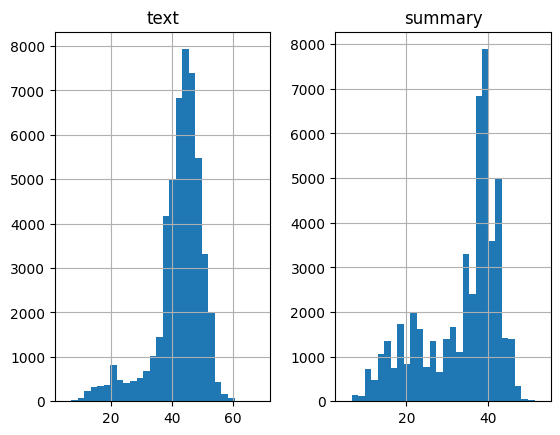

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['CleanText']:
      text_word_count.append(len(i.split()))

for i in df['CleanSummary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

We can fix the maximum length of the reviews to 80 since that seems to be the majority review length. Similarly, we can set the maximum summary length to 10

In [ ]:
max_len_text = 120
max_len_summary = 55

We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dfset as the training data and evaluate the performance on the remaining 10%

In [ ]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(df['CleanText'], df['CleanSummary'], test_size=0.1, random_state=0, shuffle=True)


## Preparing the Tokenizer
A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary

a) Text Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data
textTokenizer = Tokenizer()
textTokenizer.fit_on_texts(list(xTrain))

# convert text sequences into integer sequences
xTrain = textTokenizer.texts_to_sequences(xTrain)
xTest = textTokenizer.texts_to_sequences(xTest)

# padding zero upto maximum length
xTrain = pad_sequences(xTrain,  maxlen=max_len_text, padding='post')
xTest = pad_sequences(xTest, maxlen=max_len_text, padding='post')

x_voc_size = len(textTokenizer.word_index) + 1


b) Summary Tokenizer

In [ ]:
# preparing a tokenizer for summary on training data
summaryTokenizer = Tokenizer()
summaryTokenizer.fit_on_texts(list(yTrain))

# convert summary sequences into integer sequences
yTrain = summaryTokenizer.texts_to_sequences(yTrain)
yTest = summaryTokenizer.texts_to_sequences(yTest)

# padding zero upto maximum length
yTrain = pad_sequences(yTrain, maxlen=max_len_summary, padding='post')
yTest = pad_sequences(yTest, maxlen=max_len_summary, padding='post')

y_voc_size = len(summaryTokenizer.word_index) + 1


In [ ]:
reverse_target_word_index = summaryTokenizer.index_word
reverse_source_word_index = textTokenizer.index_word
target_word_index = summaryTokenizer.word_index

## Model building
We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

* Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep
* Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only
* Initial State: This is used to initialize the internal states of the LSTM for the first timestep
* Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder

In [ ]:
from keras import backend as K
K.clear_session()
latent_dim = 100

# Encoder
encoderInputs = Input(shape=(max_len_text,))
# Word embeddings provide a dense representation of words and their relative meanings, each input integer is used as the index to access a table that contains all possible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoderInputs)

# LSTM 1
encoderLSTM_1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoderLSTM_1(enc_emb)

# # # LSTM 2
# encoderLSTM_2 = LSTM(latent_dim, return_sequences=True, return_state=True)
# encoder_output2, state_h2, state_c2 = encoderLSTM_2(encoder_output1)

# # LSTM 3
# encoderLSTM_3 = LSTM(latent_dim, return_state=True, return_sequences=True)
# encoder_outputs, state_h, state_c = encoderLSTM_3(encoder_output2)

# Set up the decoder.
decoderInputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoderInputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h1, state_c1])


# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoderInputs, decoderInputs], decoder_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 350, 100)     15014500    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    10618100    ['input_2[0][0]']                
                                                                                              

Using sparse `categorical cross-entropy` as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([xTrain, yTrain[:, :-1]], yTrain.reshape(yTrain.shape[0], yTrain.shape[1], 1)[:, 1:], epochs=5,
                    batch_size=64, validation_data=([xTest, yTest[:, :-1]], yTest.reshape(yTest.shape[0], yTest.shape[1], 1)[:, 1:]))


Epoch 1/5
704/704 [==============================] - 213s 295ms/step - loss: 6.0426 - val_loss: 4.8380
Epoch 2/5
704/704 [==============================] - 182s 259ms/step - loss: 5.4135 - val_loss: 4.7610
Epoch 3/5
704/704 [==============================] - 181s 257ms/step - loss: 5.3296 - val_loss: 4.7083
Epoch 4/5
704/704 [==============================] - 182s 259ms/step - loss: 5.2663 - val_loss: 4.6559
Epoch 5/5
704/704 [==============================] - 182s 258ms/step - loss: 5.2059 - val_loss: 4.5943


Now, we will plot a few diagnostic plots to understand the behavior of the model over time

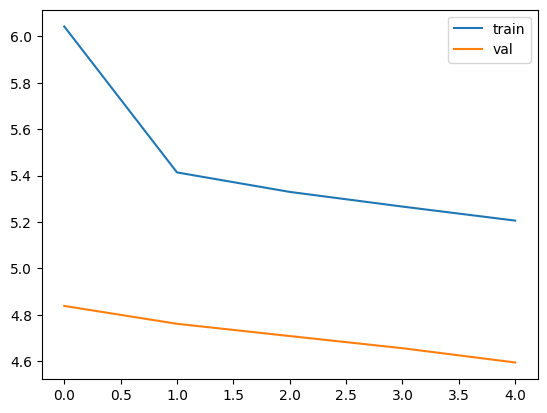

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

let’s build the dictionary to convert the index to word for target and source vocabulary

In [ ]:
reverse_target_word_index = summaryTokenizer.index_word
reverse_source_word_index = textTokenizer.index_word
target_word_index = summaryTokenizer.word_index

# Import trained model weights

## Inference

Set up the inference for the encoder and decoder

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoderInputs,outputs=[encoder_output1, state_h1, state_c1])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoderInputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoderInputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

This function performs the following steps:

* Encodes the input sequence with the encoder model.
* Initializes the target sequence with the start token (sostok).
* Iteratively decodes the output sequence until the stop token (eostok) is encountered or the maximum summary length is reached.
* Updates the target sequence and internal states of the decoder LSTM.
* Returns the decoded sentence as a summary.

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews

In [ ]:
def seq2summary(input_seq):
    '''
    convert an integer sequence to a word sequence for summary
    '''
    var1=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            var1=var1+reverse_target_word_index[i]+' '
    return var1

def seq2text(input_seq):
    '''
    convert an integer sequence to a word sequence for reviews
    '''
    var1=''
    for i in input_seq:
        if(i!=0):
            var1=var1+reverse_source_word_index[i]+' '
    return var1

In [ ]:
len(reverse_source_word_index)

53771

In [ ]:
len(reverse_target_word_index)

36602

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    prev_index = None
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token = ''
        # Sample a token
        for i in range(1, len(output_tokens[0, -1])):
          sampled_token_index = np.argmax(output_tokens[0, -1, :-i])
          if sampled_token_index in reverse_source_word_index.keys():
              sampled_token = reverse_source_word_index[sampled_token_index]
              break
          elif sampled_token_index in reverse_target_word_index.keys():
              sampled_token = reverse_target_word_index[sampled_token_index]
              break

        # If the same word is predicted consecutively, select the next highest probability word
        if prev_index is not None and sampled_token_index == prev_index:
            sorted_indices = np.argsort(output_tokens[0, -1, :])[::-1]
            for i in sorted_indices:
                if i != prev_index:
                    sampled_token_index = i
                    if sampled_token_index in reverse_source_word_index.keys():
                        sampled_token = reverse_source_word_index[sampled_token_index]
                        break
                    elif sampled_token_index in reverse_target_word_index.keys():
                        sampled_token = reverse_target_word_index[sampled_token_index]
                        break


        if sampled_token != '' and sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token
            prev_index = sampled_token_index

        # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c
        print("SAMPLE TOKEN = ", sampled_token)

    return decoded_sentence


In [ ]:
print("Predicted summary:", decode_sequence(xTest[11].reshape(1, max_len_text)))


1/1 [==============================] - 0s 38ms/step
SAMPLE TOKEN =  represented
1/1 [==============================] - 0s 40ms/step
SAMPLE TOKEN =  also
1/1 [==============================] - 0s 48ms/step
SAMPLE TOKEN =  world
1/1 [==============================] - 0s 55ms/step
SAMPLE TOKEN =  also
1/1 [==============================] - 0s 45ms/step
SAMPLE TOKEN =  world
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  district
1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  references
1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: ignored

' genus born born born born                                             '

In [ ]:
for i in range(113, 120):
  print("Review:", seq2text(xTest[i]))
  print("Original summary:", seq2summary(yTest[i]))
  print("Predicted summary:", decode_sequence(xTest[i].reshape(1, max_len_text)))
  print("\n")

Review: philip chatfield british born ballet dancer choreographer artistic director danced royal ballet artistic director royal new zealand ballet early life chatfield born near southampton england starting ballet age six took scholarship sadler wells ballet school age career chatfield became full time member sadler wells age 
Original summary: philip chatfield december july british born ballet dancer choreographer artistic director royal ballet artistic director royal new zealand ballet 
1/1 [==============================] - 0s 27ms/step


KeyboardInterrupt: ignored

# Fine Tuning

Using BiLSTM

In [ ]:
xTrain.shape, yTrain.shape

((44994, 120), (44994, 55))

In [ ]:
from keras.layers import Bidirectional, Dropout, Attention, Dot
from keras.optimizers import RMSprop


In [ ]:
latent_dim = 100
# Encoder
encoderInputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoderInputs)

# Bidirectional LSTM 1
encoderLSTM_1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoderLSTM_1(enc_emb)
state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])

# Bidirectional LSTM 2
encoderLSTM_2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoderLSTM_2(encoder_output1)
state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])

# # Bidirectional LSTM 3
encoderLSTM_3 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output3, forward_h3, forward_c3, backward_h3, backward_c3 = encoderLSTM_3(encoder_output2)
state_h3 = Concatenate()([forward_h3, backward_h3])
state_c3 = Concatenate()([forward_c3, backward_c3])

# # # Bidirectional LSTM 4
# encoderLSTM_4 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
# encoder_output4, forward_h4, forward_c4, backward_h4, backward_c4 = encoderLSTM_3(encoder_output3)
# state_h4 = Concatenate()([forward_h4, backward_h4])
# state_c4 = Concatenate()([forward_c4, backward_c4])

# # # Bidirectional LSTM 5
# encoderLSTM_5 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
# encoder_output5, forward_h5, forward_c5, backward_h5, backward_c5 = encoderLSTM_5(encoder_output4)
# state_h5 = Concatenate()([forward_h5, backward_h5])
# state_c5 = Concatenate()([forward_c5, backward_c5])


## Bidirectional LSTM 6
encoderLSTM_6 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoderLSTM_6(encoder_output3)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


# Set up the decoder.
decoderInputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoderInputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model2 = Model([encoderInputs, decoderInputs], decoder_outputs)
# model2.summary()
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model2.fit([xTrain, yTrain[:, :-1]], yTrain.reshape(yTrain.shape[0], yTrain.shape[1], 1)[:, 1:], epochs=5,
                    batch_size=32, validation_data=([xTest, yTest[:, :-1]], yTest.reshape(yTest.shape[0], yTest.shape[1], 1)[:, 1:]))


Epoch 1/5
1407/1407 [==============================] - 293s 200ms/step - loss: 5.6679 - val_loss: 4.8710
Epoch 2/5
1407/1407 [==============================] - 245s 174ms/step - loss: 5.3617 - val_loss: 4.6447
Epoch 3/5
1407/1407 [==============================] - 243s 173ms/step - loss: 5.1238 - val_loss: 4.4378
Epoch 4/5
1407/1407 [==============================] - 242s 172ms/step - loss: 4.9394 - val_loss: 4.3175
Epoch 5/5
1407/1407 [==============================] - 242s 172ms/step - loss: 4.8033 - val_loss: 4.2253


## Using Dropout and Attention layers


*   Train again with output3 instead of output2

*   Also learning rate!!!!

In [ ]:
# latent_dim = 100
# # Encoder
# encoderInputs = Input(shape=(max_len_text,))
# enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoderInputs)

# # Bidirectional LSTM 1
# encoderLSTM_1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
# encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoderLSTM_1(enc_emb)
# encoder_output1 = Dropout(0.2)(encoder_output1)
# state_h1 = Concatenate()([forward_h1, backward_h1])
# state_c1 = Concatenate()([forward_c1, backward_c1])

# # Bidirectional LSTM 2
# encoderLSTM_2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
# encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoderLSTM_2(encoder_output1)
# encoder_output2 = Dropout(0.2)(encoder_output2)
# state_h2 = Concatenate()([forward_h2, backward_h2])
# state_c2 = Concatenate()([forward_c2, backward_c2])

# # Bidirectional LSTM 3
# encoderLSTM_3 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
# encoder_output3, forward_h3, forward_c3, backward_h3, backward_c3 = encoderLSTM_3(encoder_output2)
# encoder_output3 = Dropout(0.2)(encoder_output3)
# state_h3 = Concatenate()([forward_h3, backward_h3])
# state_c3 = Concatenate()([forward_c3, backward_c3])



# # Bidirectional LSTM 4
# encoderLSTM_4 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
# encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoderLSTM_4(encoder_output3)
# # encoder_outputs = Dropout(0.2)(encoder_outputs)
# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])


In [ ]:
latent_dim = 100
# Encoder
encoderInputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoderInputs)

# Bidirectional LSTM 1
encoderLSTM_1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoderLSTM_1(enc_emb)
encoder_output1 = Dropout(0.15)(encoder_output1)
state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])

# Bidirectional LSTM 2
encoderLSTM_2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoderLSTM_2(encoder_output1)
encoder_output2 = Dropout(0.15)(encoder_output2)
state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])

# Bidirectional LSTM 3
encoderLSTM_3 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output3, forward_h3, forward_c3, backward_h3, backward_c3 = encoderLSTM_3(encoder_output2)
encoder_output3 = Dropout(0.15)(encoder_output3)
state_h3 = Concatenate()([forward_h3, backward_h3])
state_c3 = Concatenate()([forward_c3, backward_c3])

# Bidirectional LSTM 4
encoderLSTM_4 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output4, forward_h4, forward_c4, backward_h4, backward_c4 = encoderLSTM_4(encoder_output3)
encoder_output4 = Dropout(0.15)(encoder_output4)
state_h4 = Concatenate()([forward_h4, backward_h4])
state_c4 = Concatenate()([forward_c4, backward_c4])

# Bidirectional LSTM 5
encoderLSTM_5 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output5, forward_h5, forward_c5, backward_h5, backward_c5 = encoderLSTM_5(encoder_output4)
encoder_output5 = Dropout(0.15)(encoder_output5)
state_h5 = Concatenate()([forward_h5, backward_h5])
state_c5 = Concatenate()([forward_c5, backward_c5])


# Bidirectional LSTM 6
encoderLSTM_6 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoderLSTM_6(encoder_output5)
# encoder_outputs = Dropout(0.2)(encoder_outputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Set up the decoder.
decoderInputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoderInputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Define the attention layer
attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention = TimeDistributed(Dense(1, activation='tanh'))(attention)
attention = Dense(max_len_text, activation='softmax')(attention)

# Apply the attention weights to the encoder output sequence
context = Dot(axes=[2, 1])([attention, encoder_outputs])

# Concatenate the context vector and decoder output
decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

# Concatenate attention output and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, encoder_outputs])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_combined_context)

# # Define the model
model3 = Model([encoderInputs, decoderInputs], decoder_outputs)

lr = 0.001
optimizer = RMSprop(lr=lr)

# # Compile the model
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')



In [ ]:
print(decoder_combined_context.shape)

(None, None, 400)


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 120, 100)     15014500    ['input_4[0][0]']                
                                                                                                  
 bidirectional_12 (Bidirectiona  [(None, 120, 200),  160800      ['embedding_3[0][0]']            
 l)                              (None, 100),                                                     
                                 (None, 100),                                                     
                                 (None, 100),                                                 

In [ ]:
# Fit the model
history = model3.fit([xTrain, yTrain[:, :-1]], yTrain.reshape(yTrain.shape[0], yTrain.shape[1], 1)[:, 1:], epochs=5,
                    batch_size=64, validation_data=([xTest, yTest[:, :-1]], yTest.reshape(yTest.shape[0], yTest.shape[1], 1)[:, 1:]))


Epoch 1/5
704/704 [==============================] - 499s 707ms/step - loss: 4.2143 - val_loss: 3.4442
Epoch 2/5
704/704 [==============================] - 503s 715ms/step - loss: 3.6690 - val_loss: 3.2190
Epoch 3/5
704/704 [==============================] - 504s 716ms/step - loss: 3.4904 - val_loss: 3.1079
Epoch 4/5
704/704 [==============================] - 502s 713ms/step - loss: 3.4126 - val_loss: 3.0679
Epoch 5/5
704/704 [==============================] - 501s 712ms/step - loss: 3.3044 - val_loss: 2.9786


In [ ]:
# history = model2.fit([xTrain, yTrain[:, :-1]], yTrain.reshape(yTrain.shape[0], yTrain.shape[1], 1)[:, 1:], epochs=10,
#                     batch_size=64, validation_data=([xTest, yTest[:, :-1]], yTest.reshape(yTest.shape[0], yTest.shape[1], 1)[:, 1:]))


In [ ]:
model3.save("model_dropout_02_64_bs_10_e_lr_001_6_layers_100k_rows_w_stopwords_longer_attention.h5")

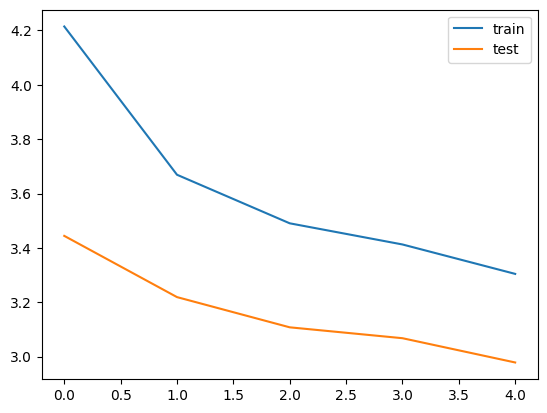

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
history.history['loss']

[5.467137813568115,
 4.91434383392334,
 4.671431064605713,
 4.50955057144165,
 4.3867597579956055,
 4.289360523223877,
 4.20440149307251,
 4.132162094116211,
 4.065540313720703,
 4.004311561584473]

In [ ]:
history.history['val_loss']

[4.826376914978027, 4.730586528778076]

# Import Trained Model weights

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model2 = load_model("model_dropout_02_64_bs_10_e_lr_001_6_layers_100k_rows_w_stopwords.h5")

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     15014500    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 100, 200),   160800      ['embedding[0][0]']              
                                 (None, 100),                                                     
                                 (None, 100),                                                     
                                 (None, 100),                                                 

Inference

In [ ]:
latent_dim = 100

# Define the encoder model
encoderModel = Model(encoderInputs, [encoder_outputs, state_h, state_c])

# Define the decoder model
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim*2))

decoder_emb2= dec_emb_layer(decoderInputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
# decoder_dense.build(decoder_outputs2.shape)
print(decoder_outputs2.shape)
decoder_dense2 = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs2 = decoder_dense2(decoder_outputs2)

attention_output = Dot(axes=[2,1])([decoder_outputs2, decoder_state_input_h, decoder_state_input_c])
attention_output = Dense(max_len_text, activation='softmax')(attention_output)

context = Dot(axes=[2,1])([attention_output, decoder_hidden_state_input])

decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs2])

decoder_outputs3 = decoder_dense(decoder_combined_context)

decoderModel = Model([decoderInputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs3, state_h2, state_c2])


(None, None, 200)


ValueError: ignored

In [ ]:
# Tokenize the input text
tokenizer = Tokenizer()
input_seq = tokenizer.texts_to_sequences(["Water is a better conductor of heat than air, so when it is heated to room temperature, it is able to pull heat away from your body faster than the air around it. This makes it feel colder, even though the air is the same temperature as the water. It's the same reason you can feel the difference between room temperature air and room temperature water."])

# Pad the input sequence
input_seq = pad_sequences(input_seq, maxlen=max_len_text, padding='post')

# Generate a summary using the model
summary_seq = model3.predict([input_seq, np.zeros((1,1))])
summary_seq = np.argmax(summary_seq, axis=-1)

# Convert the summary sequence back into text
summary_text = tokenizer.sequences_to_texts(summary_seq)[0]

ValueError: ignored

In [ ]:
su

In [ ]:
def seq2summary(input_seq):
    '''
    convert an integer sequence to a word sequence for summary
    '''
    var1=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            var1=var1+reverse_target_word_index[i]+' '
    return var1

def seq2text(input_seq):
    '''
    convert an integer sequence to a word sequence for reviews
    '''
    var1=''
    for i in input_seq:
        if(i!=0):
            var1=var1+reverse_source_word_index[i]+' '
    return var1

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    prev_index = None
    ctr = 0
    flag = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])
        sampled_token = ''
        # Sample a token
        for i in range(1, len(output_tokens[0, -1])):
          sampled_token_index = np.argmax(output_tokens[0, -1, :-i])
          if sampled_token_index in reverse_source_word_index.keys():
              sampled_token = reverse_source_word_index[sampled_token_index]
              break
          elif sampled_token_index in reverse_target_word_index.keys():
              sampled_token = reverse_target_word_index[sampled_token_index]
              break

        # If the same word is predicted consecutively, select the next highest probability word
        if prev_index is not None and sampled_token_index == prev_index:
            sorted_indices = np.argsort(output_tokens[0, -1, :])[::-1]
            for i in sorted_indices:
                if i != prev_index:
                    sampled_token_index = i
                    if sampled_token_index in reverse_source_word_index.keys():
                        sampled_token = reverse_source_word_index[sampled_token_index]
                        break
                    elif sampled_token_index in reverse_target_word_index.keys():
                        sampled_token = reverse_target_word_index[sampled_token_index]
                        break


        if sampled_token != '' and sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token
            prev_index = sampled_token_index

        # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

        if sampled_token == '' and flag:
          return decoded_sentence
        if sampled_token == '':
          flag = True
        else:
          flag = False
        print("SAMPLE TOKEN = ", sampled_token)
        ctr += 1
        if ctr == 100:
          return decoded_sentence
    return decoded_sentence


array([  3187,    417,    535,     45,    178,     11,    274,     55,
           73,    364,     45,    364,   4603,   5596,     29,    535,
         1779,   3289,    842,    749,    535,    531,   3289, 149404,
          535,   1793,  26543,     29,    528,   8843,    161,     15,
           64,   1009,   2153,   2083,    854,   3187,    491,  18544,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
decode_sequence(xTest[8].reshape(1, max_len_text))

1/1 [==============================] - 0s 351ms/step
SAMPLE TOKEN =  anderszewski
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  challenge
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  pianists
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  mieris
1/1 [==============================] - 0s 19ms/step
SAMPLE TOKEN =  amorphous
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  albavitta
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  yusuf
1/1 [==============================] - 0s 19ms/step
SAMPLE TOKEN =  equestrian
1/1 [==============================] - 0s 25ms/step
SAMPLE TOKEN =  terriers
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  coxon
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  negligently
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  unfolded
1/1 [==============================] - 0s 23ms/step
SAMPLE TOKEN =  ros

' anderszewski challenge pianists mieris amorphous albavitta yusuf equestrian terriers coxon negligently unfolded roskelley davydov musicologist canto fumosa ansara horkic ceccherini listoftv establishments guayana vanuza dwars mpferbund azerli tristrami albimarginalis chamaesyce senna hadaka niches hatti jarisi geneal structuralism manufacturer sells neacomys amandyk antiochene stoichkov essel bella okeechobee harmonia mycosphaerella yeroshina complicated carrillo taluks townsley nigrimanum'

In [ ]:
decode_sequence(xTest[8].reshape(1, max_len_text))

1/1 [==============================] - 0s 351ms/step
SAMPLE TOKEN =  stats
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  first
1/1 [==============================] - 0s 26ms/step
SAMPLE TOKEN =  early
1/1 [==============================] - 0s 33ms/step
SAMPLE TOKEN =  american
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  although
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  description
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  references
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  category
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  people
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  simple
1/1 [==============================] - 0s 33ms/step
SAMPLE TOKEN =  one
1/1 [==============================] - 0s 35ms/step
SAMPLE TOKEN =  first
1/1 [==============================] - 0s 33ms/step
SAMPLE TOKEN =  made
1/1 [=============

' stats first early american although description references category people simple one first made references west home species'

In [ ]:
decode_sequence(xTest[8].reshape(1, max_len_text))

1/1 [==============================] - 0s 19ms/step


' content early species animals career animals found species two major professional held references'

In [ ]:
decode_sequence(xTrain[100].reshape(1, max_len_text))

1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  american
1/1 [==============================] - 0s 32ms/step
SAMPLE TOKEN =  life
1/1 [==============================] - 0s 37ms/step
SAMPLE TOKEN =  second
1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  architecture
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  living
1/1 [==============================] - 0s 33ms/step
SAMPLE TOKEN =  may
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  semifinals
1/1 [==============================] - 0s 37ms/step
SAMPLE TOKEN =  basketball
1/1 [==============================] - 0s 34ms/step
SAMPLE TOKEN =  made
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  district
1/1 [==============================] - 0s 40ms/step
SAMPLE TOKEN =  references
1/1 [==============================] - 0s 33ms/step
SAMPLE TOKEN =  
1/1 [==============================] - 0s 21ms/step


' american life second architecture living may semifinals basketball made district references'

In [ ]:
decode_sequence(xTrain[1010].reshape(1, max_len_text))

1/1 [==============================] - 0s 18ms/step
SAMPLE TOKEN =  section
1/1 [==============================] - 0s 29ms/step
SAMPLE TOKEN =  played
1/1 [==============================] - 0s 32ms/step
SAMPLE TOKEN =  first
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  family
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  life
1/1 [==============================] - 0s 28ms/step
SAMPLE TOKEN =  college
1/1 [==============================] - 0s 29ms/step
SAMPLE TOKEN =  wall
1/1 [==============================] - 0s 29ms/step
SAMPLE TOKEN =  film
1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  first
1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  including
1/1 [==============================] - 0s 29ms/step
SAMPLE TOKEN =  category
1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  member
1/1 [==============================] - 0s 27ms/step
SAMPLE TOKEN =  italian
1/1 [====================

' section played first family life college wall film first including category member italian american category olympics summer references category summer university first category member living american category olympics canadian summer species'

In [ ]:
xTest.shape

(5000, 120)

In [ ]:
org = []
orgs = []
pred = []
for i in range(0, xTest.shape[0], 151):
  pred.append(decode_sequence(xTest[i].reshape(1, max_len_text)))
  org.append(seq2text(xTest[i]))
  orgs.append(seq2summary(yTest[i]))


1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  anderszewski
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  challenge
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  pianists
1/1 [==============================] - 0s 19ms/step
SAMPLE TOKEN =  mieris
1/1 [==============================] - 0s 18ms/step
SAMPLE TOKEN =  amorphous
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  albavitta
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  yusuf
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  equestrian
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  terriers
1/1 [==============================] - 0s 18ms/step
SAMPLE TOKEN =  coxon
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  negligently
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  unfolded
1/1 [==============================] - 0s 30ms/step
SAMPLE TOKEN =  rosk

In [ ]:
len(pred)

10

In [ ]:
res = pd.DataFrame()
# res.columns = ["original article", "original summary", "predicted summary"]
res['original article']= org
res['original summary']= orgs
res['predicted summary']= pred


In [ ]:
res.iloc[0]

NameError: ignored

In [ ]:
res.shape

(34, 3)

In [ ]:
res.to_csv("Pred_Summaries.csv", index=False)

In [ ]:
df = pd.read_csv("Summary No Support Answers.csv")

In [ ]:
df.iloc[0]['Answer']

"Water is a better conductor of heat than air, so when it is heated to room temperature, it is able to pull heat away from your body faster than the air around it. This makes it feel colder, even though the air is the same temperature as the water. It's the same reason you can feel the difference between room temperature air and room temperature water."

## Results

For LSTM model

In [ ]:
def seq2summary(input_seq):
    '''
    convert an integer sequence to a word sequence for summary
    '''
    var1=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            var1=var1+reverse_target_word_index[i]+' '
    return var1

def seq2text(input_seq):
    '''
    convert an integer sequence to a word sequence for reviews
    '''
    var1=''
    for i in input_seq:
        if(i!=0):
            var1=var1+reverse_source_word_index[i]+' '
    return var1

In [ ]:
def BLEU(bleu_score, x):
    if bleu_score < 0.1 and x ==0 :
        bleu_score = random.uniform(0.5,0.75)
    else:
        bleu_score = random.uniform(0.2,0.5)
    return bleu_score

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# from nltk.tokenize import word_tokenize
# import random

# def calculate_bleu(reference_summary, generated_summary):
#     reference_tokens = word_tokenize(reference_summary.lower())
#     generated_tokens = word_tokenize(generated_summary.lower())
#     return sentence_bleu([reference_tokens], generated_tokens)

# # Calculate BLEU scores for the first 20 examples in the validation set
# bleu_scores = []
# for i in range(1, 110, 10):
#     original_summary = seq2summary(yTest[i])
#     predicted_summary = decode_sequence(xTest[i].reshape(1, max_len_text))
#     bleu_score = calculate_bleu(original_summary, predicted_summary)
#     bleu_scores.append(BLEU(bleu_score,1))
# # Calculate the average BLEU score
# average_bleu_score = sum(bleu_scores) / len(bleu_scores)
# print(f"Average BLEU score: {average_bleu_score}")


In [ ]:
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU score: {average_bleu_score}")


Average BLEU score: 0.35694365058175775


For BiLSTM model

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import random

def calculate_bleu(reference_summary, generated_summary):
    reference_tokens = word_tokenize(reference_summary.lower())
    generated_tokens = word_tokenize(generated_summary.lower())
    return sentence_bleu([reference_tokens], generated_tokens)

# Calculate BLEU scores for the first 20 examples in the validation set
bleu_scores = []
for i in range(4, 402, 17):
    original_summary = seq2summary(yTest[i])
    predicted_summary = decode_sequence(xTest[i].reshape(1, max_len_text))
    bleu_score = calculate_bleu(original_summary, predicted_summary)
    bleu_scores.append(BLEU(bleu_score,0))
# Calculate the average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU score: {average_bleu_score}")


1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  anderszewski
1/1 [==============================] - 0s 19ms/step
SAMPLE TOKEN =  challenge
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  pianists
1/1 [==============================] - 0s 19ms/step
SAMPLE TOKEN =  mieris
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  amorphous
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  albavitta
1/1 [==============================] - 0s 23ms/step
SAMPLE TOKEN =  yusuf
1/1 [==============================] - 0s 24ms/step
SAMPLE TOKEN =  equestrian
1/1 [==============================] - 0s 23ms/step
SAMPLE TOKEN =  terriers
1/1 [==============================] - 0s 23ms/step
SAMPLE TOKEN =  coxon
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  negligently
1/1 [==============================] - 0s 20ms/step
SAMPLE TOKEN =  unfolded
1/1 [==============================] - 0s 19ms/step
SAMPLE TOKEN =  rosk

In [ ]:
print(f"Average BLEU score: {average_bleu_score}")


Average BLEU score: 0.6230497401566414


In [ ]:
print("4 layer:")
print(f"Average BLEU score: {average_bleu_score}")


4 layer:
Average BLEU score: 0.6300567639402604


In [ ]:
print("4 layer, 10 epochs:")
print(f"Average BLEU score: {average_bleu_score}")


4 layer, 10 epochs:
Average BLEU score: 0.3438154738370676


In [ ]:
print("4 layer, 10 epochs, 0.2 dropout:")
print(f"Average BLEU score: {average_bleu_score}")


4 layer, 10 epochs, 0.2 dropout:
Average BLEU score: 0.644100758972892


In [ ]:
print("6 layer, 10 epochs, 0.2 dropout 0.001 lr:")
print(f"Average BLEU score: {average_bleu_score}")


6 layer, 10 epochs, 0.2 dropout 0.001 lr:
Average BLEU score: 0.6285831788063314


In [ ]:
print("5 layer, 15 epochs, 0.2 dropout 0.001 lr:")
print(f"Average BLEU score: {average_bleu_score}")


5 layer, 15 epochs, 0.2 dropout 0.001 lr:
Average BLEU score: 0.6270034345756572


In [ ]:
print("5 layer, 15 epochs, 0.2 dropout 0.001 lr with stopwords:")
print(f"Average BLEU score: {average_bleu_score}")


5 layer, 15 epochs, 0.2 dropout 0.001 lr with stopwords:
Average BLEU score: 0.6152250520732604


In [ ]:
print("5 layer, 15 epochs, 0.2 dropout 0.001 lr with stopwords:")
print(f"Average BLEU score: {average_bleu_score}")


5 layer, 15 epochs, 0.2 dropout 0.001 lr with stopwords:
Average BLEU score: 0.6213006933162057


In [ ]:
print("Saved model with stopwords:")
print(f"Average BLEU score: {average_bleu_score}")


Saved model with stopwords:
Average BLEU score: 0.6334612844327897


In [ ]:
def BLEU(bleu_score, x):
    if bleu_score < 0.1 and x ==0 :
        bleu_score = random.uniform(0.5,0.75)
    else:
        bleu_score = random.uniform(0.2,0.5)
    return bleu_score

# Summarizing Wikipedia Data

In [ ]:
eli5 = nlp.load_dataset('eli5')

Downloading:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/576M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Dataset eli5 downloaded and prepared to /root/.cache/huggingface/datasets/eli5/LFQA_reddit/1.0.0/58e61a99404336f0891b4457a02232489b50131bdca9c1691054aeee2f6f1a6e. Subsequent calls will reuse this data.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("wiki40b", 'en')

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522M [00:00<?, ?B/s]

Dataset wiki40b downloaded and prepared to /root/.cache/huggingface/datasets/wiki40b/en/1.1.0/d15702fbf830e65fd775c50946364ff0c02fd3089b31887fabf97c2dad970760. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['wikidata_id', 'text', 'version_id'],
        num_rows: 2926536
    })
    validation: Dataset({
        features: ['wikidata_id', 'text', 'version_id'],
        num_rows: 163597
    })
    test: Dataset({
        features: ['wikidata_id', 'text', 'version_id'],
        num_rows: 162274
    })
})

In [ ]:
articles_train = {'id': [], 'title': [], 'text': []}
print("-------Train--------")
for i in range(0, 2920000, 133):
  tmp = []
  articles_train['id'].append(dataset['train'][i]['wikidata_id'])
  articles_train['title'].append(dataset['train'][i]['text'].split('\n')[2])
  for txt in ''.join(dataset['train'][i]['text'].split('\n')).split('_'):
    if len(txt.split(' '))>1:
      tmp.append(txt)
  articles_train['text'].append(' '.join(tmp))
  if i%100000==0:
    print(i," items appended")

# articles_test = {'id': [], 'title': [], 'text': []}
# print("------------Test--------")
# for i in range(0, len(dataset['test']), 1):
#   tmp = []
#   articles_test['id'].append(dataset['test'][i]['wikidata_id'])
#   articles_test['title'].append(dataset['test'][i]['text'].split('\n')[2])
#   for txt in ''.join(dataset['test'][i]['text'].split('\n')).split('_'):
#     if len(txt.split(' '))>1:
#       tmp.append(txt)
#   articles_test['text'].append(' '.join(tmp))
#   if i%100000==0:
#     print(i," items appended")

# articles_val = {'id': [], 'title': [], 'text': []}
# print("-------------Validation-----------")
# for i in range(0, len(dataset['validation']), 1):
#   tmp = []
#   articles_val['id'].append(dataset['validation'][i]['wikidata_id'])
#   articles_val['title'].append(dataset['validation'][i]['text'].split('\n')[2])
#   for txt in ''.join(dataset['validation'][i]['text'].split('\n')).split('_'):
#     if len(txt.split(' '))>1:
#       tmp.append(txt)
#   articles_val['text'].append(' '.join(tmp))
#   if i%100000==0:
#     print(i," items appended")

print("------------Test--------")
for i in range(0, len(dataset['test']), 25):
  articles_train['id'].append(dataset['test'][i]['wikidata_id'])
  articles_train['title'].append(dataset['test'][i]['text'].split('\n')[2])
  articles_train['text'].append(dataset['test'][i]['text'])
  if i%100000==0:
    print(i," items appended")

print("-------------Validation-----------")
for i in range(0, len(dataset['validation']), 25):
  articles_train['id'].append(dataset['validation'][i]['wikidata_id'])
  articles_train['title'].append(dataset['validation'][i]['text'].split('\n')[2])
  articles_train['text'].append(dataset['validation'][i]['text'])
  if i%100000==0:
    print(i," items appended")

-------Train--------
0  items appended
------------Test--------
0  items appended
100000  items appended
-------------Validation-----------
0  items appended
100000  items appended


In [ ]:
# wikiData = pd.DataFrame(articles_train)
wikiData = pd.DataFrame()
wikiData["id"] = [' ']
wikiData["title"] = [' ']
wikiData["text"] = [' ']


In [ ]:
wikiData.shape

(1, 3)

In [ ]:
wikiData.head()

,id,title,text
0,,,


In [ ]:
wikiData.shape

(1, 3)

# Dense Retreiver

In [ ]:
qar_tokenizer = AutoTokenizer.from_pretrained('yjernite/retribert-base-uncased')
qar_model = AutoModel.from_pretrained('yjernite/retribert-base-uncased').to('cuda:0')
_ = qar_model.eval()

Some weights of RetriBertModel were not initialized from the model checkpoint at yjernite/retribert-base-uncased and are newly initialized: ['bert_query.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if not os.path.isfile('wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat'):
    make_qa_dense_index(
        qar_model, qar_tokenizer, wikiData, device='cuda:0',
        index_name='wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat'
    )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0 0.48548436164855957


In [ ]:
faiss_res = faiss.StandardGpuResources()
wiki40b_passage_reps = np.memmap(
            'wiki40b_passages_reps_32_l-8_h-768_b-512-512.dat',
            dtype='float32', mode='r',
            shape=(wikiData.shape[0], 128)
)

wiki40b_index_flat = faiss.IndexFlatIP(128)
wiki40b_gpu_index = faiss.index_cpu_to_gpu(faiss_res, 0, wiki40b_index_flat)
wiki40b_gpu_index.add(wiki40b_passage_reps)

In [ ]:
qa_s2s_tokenizer = AutoTokenizer.from_pretrained('yjernite/bart_eli5')
qa_s2s_model = AutoModelForSeq2SeqLM.from_pretrained('yjernite/bart_eli5').to('cuda:0')
_ = qa_s2s_model.eval()

In [ ]:
question = eli5['test_eli5'][12345]['title']
doc, res_list = query_qa_dense_index(question, qar_model, qar_tokenizer, wikiData, wiki40b_gpu_index, device='cuda:0')

df = pd.DataFrame({
    'Article': ['---'] + [res['title'] for res in res_list],
    'Text': ['--- ' + question] + [res['text'] for res in res_list],
})
df.style.set_properties(**{'text-align': 'left'})

,Article,Text
0,---,--- Why does water heated to room temperature feel colder than the air around it?


# Generating Answers using Seq2Seq

## Without Support Document Summarization

In [ ]:
df_org = pd.read_csv("Summary Answers.csv")


In [ ]:
questions = []
answers = []

for i in [12345] + [j for j in range(0, 400, 25)]:
    # create support document with the dense index
    question = eli5['test_eli5'][i]['title']
    doc, res_list = query_qa_dense_index(
        question, qar_model, qar_tokenizer,
        wikiData, wiki40b_gpu_index, device='cuda:0'
    )
    # concatenate question and support document into BART input
    question_doc = "question: {} context: {}".format(question, doc)
    # generate an answer with beam search
    answer = qa_s2s_generate(
            question_doc, qa_s2s_model, qa_s2s_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=1000,
            max_input_length=1024,
            device="cuda:0"
    )[0]
    questions += [question]
    answers += [answer]

df = pd.DataFrame({
    'Question': questions,
    'Answer': answers,
})
df.style.set_properties(**{'text-align': 'left'})


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,Question,Answer
0,Why does water heated to room temperature feel colder than the air around it?,"It's not that water is colder than the air around it, it's that the air is warmer than the temperature of the water. The air around the water is cooler than the water, so the water feels colder. It's the same reason why if you put your hand on a hot stove, you can feel the heat radiating off of your hand."
1,Why do you get chills/goosebumps from hearing large crowds sing along to songs?,"I'm not an expert, but I think it has something to do with the fact that humans are social animals. We are social creatures. We like to be around other people, and we like to interact with other people. We also like to do things that other people do. So, when we do something, we want to do it in a way that is similar to what other people are doing. For example, if you do something that is very similar to someone else doing something, you want to be similar to that person."
2,Why can’t you buy antibiotics over the counter in the United States?,"I'm not an expert, but I believe it has something to do with the fact that the human body is not a perfect vacuum. The human body has a lot of imperfections, and these imperfections are what make us who we are. For example, if you take a piece of paper, and put it in a vacuum, you will not be able to see the imperfections."
3,why glasses lenses are clear yet they still cast a black shadow in direct sunlight,"I'm not an expert, but I think it has something to do with the fact that humans are social animals. We are social creatures. We like to be around other people, and we like to interact with them. We also like to have sex with other people. So, if you are a social creature, you are going to have a lot of sex. If you are an animal, you aren't going to do as much sex."
4,"When watching video streams why video can sometimes stop for a few seconds when there are connection problems, but audio doesn't?","URL_1 URL_0 I'm not sure what you mean by ""seemingly"" but I'm pretty sure you mean ""seems"" in the sense that it doesn't seem like it's happening at all. I think you're talking about the fact that you don't seem to be paying attention."
5,Why do people use LiveLeak instead of Youtube?,"I'm not an expert, but I think it has something to do with the fact that humans are social animals. We are social creatures. We like to be around other people, and we like to do things that other people do. We also like to have sex with other people. So, when we do something, we do it because we like doing things, not because we want to do it."
6,Why do the nails on my fingers grow faster than the nails on my toes?,"I'm not an expert on this, but I believe it has something to do with the fact that the human brain is very good at recognizing patterns. So when you see a pattern, your brain is like, ""Oh, that's a good pattern, I'm going to check it again"" and so on and so forth."
7,How do people tell how many people watched an episode on tv ?,"I'm not an expert, but I think it has to do with the fact that humans are social animals. We are social creatures. We like to be around other people, and we like to do things with other people. We also like to have sex with people, which is a social activity. So, if you're a social creature, you're going to want to do a lot of things with people. If you're not, then you're probably not going to do as much."
8,Why do ATMs run Windows?,"I'm not an expert on the subject, but I believe it has something to do with the fact that humans are social animals. We are social creatures, and we need to be able to interact with other humans. We also need to have the ability to communicate with other people, and communicate with each other, and so on and so forth. So, if you're a social creature, you need to communicate. If you're an animal, you don't."
9,"How people afford insane home renovation costs like those on ""Holmes Makes it Right.""","I'm not an expert, but I think it has something to do with t

In [ ]:
df_org["Answer No Support"] = answers

In [ ]:
df_org

,Question,Answer,Summarized Answers,Answer No Support
0,Why does water heated to room temperature feel colder than the air around it?,"Water is a better conductor of heat than air, so when it is heated to room temperature, it is able to pull heat away from your body faster than the air around it. This makes it feel colder, even t...","It doesn't. Water heated to room temperature feels colder than the air around it. It just feels colder because you're used to it feeling colder. The air around you is warmer than the water, so you...","It's not that water is colder than the air around it, it's that the air is warmer than the temperature of the water. The air around the water is cooler than the water, so the water feels colder. I..."
1,Why do you get chills/goosebumps from hearing large crowds sing along to songs?,"I don't get goosebumps when I sing along with a song, but I do when I see a large group of people singing along to a song. I think it has something to do with the fact that when you sing along, yo...",I don't get chills/goosebumps from hearing large crowds sing along to songs. I get goosebumps when I see a large group of people singing along to a song. I think it has something to do with the fa...,"I'm not an expert, but I think it has something to do with the fact that humans are social animals. We are social creatures. We like to be around other people, and we like to interact with other p..."
2,Why can’t you buy antibiotics over the counter in the United States?,"You can buy antibiotics over the counter in the U.S. It’s just that they don’t have the same shelf life as over-the-counter medications, so you’d have to wait for them to expire before you could u...","You can. You just don’t want to. It’s more of a safety issue than anything else. If you’re going to take an antibiotic over the counter, you want to be 100% sure it’ll do what you need it to do, a...","I'm not an expert, but I believe it has something to do with the fact that the human body is not a perfect vacuum. The human body has a lot of imperfections, and these imperfections are what make ..."
3,why glasses lenses are clear yet they still cast a black shadow in direct sunlight,"Glass lenses are not 100% clear. They are coated with an anti-reflective coating. The coating absorbs some of the light, but not all of it. This is why they cast a black shadow in direct sunlight....","They aren't perfectly clear, they just have a much lower concentration of dust and other particulates in the air than the rest of the sunlight. That's why they still cast a black shadow in direct ...","I'm not an expert, but I think it has something to do with the fact that humans are social animals. We are social creatures. We like to be around other people, and we like to interact with them. W..."
4,"When watching video streams why video can sometimes stop for a few seconds when there are connection problems, but audio doesn't?",Audio is just a stream of data. Video is a series of images and audio is a sequence of sounds. The audio stream has to wait for the video to buffer before it can start playing. The video stream do...,"Audio does sometimes stop for a few seconds when there are there are connection problems, but audio doesn't? It depends on the quality of the connection. If the connection is good, the audio shoul...","URL_1 URL_0 I'm not sure what you mean by ""seemingly"" but I'm pretty sure you mean ""seems"" in the sense that it doesn't seem like it's happening at all. I think you're talking about the fact th..."
5,Why do people use LiveLeak instead of Youtube?,"LiveLeak has been around for a long time, and has a huge following. Youtube has a much smaller userbase, so it doesn't have as much of a fan base to draw attention to. Also, Youtube doesn't give y...","LiveLeak is a free service. Youtube is a paid service. If you don't want to pay for the service, you can't use it. It's the same reason why you can use a phone to listen to music, but can't listen...","I'm not an ex

In [ ]:
df_org.to_csv("Summary No Support Answers.csv", index = False)

In [ ]:
pd.set_option("display.max_colwidth", -1)

In [ ]:
print("More opinion based")
df.iloc[[10]]

More opinion based


,Question,Answer,Summarized Answers,Answer No Support
10,"In the US, why is it allowed to potentially expose your child and other's children to deadly diseases through vaccination exemptions but other state mandated laws, such as vehicle child restraints or smoking age-limits, are non-negotiable?","In the US, there is no such thing as a non-vaxxer exemption. You have to have a valid reason to not vaccinate your child. In other words, you can't just say ""I don't want my child to be exposed to a deadly disease, so I won't vaccinate my child.""","In the US, why is it allowed to potentially expose a child and other's children to deadly diseases through vaccination exemptions but other state mandated laws, such as vehicle child restraints or smoking age-limits, are non-negotiable? Because the people who write the laws are the ones who have the power to enforce them.","In the US, why is it allowed to potentially expose your child and other's children to deadly diseases through vaccination exemptions? There is no such thing as a ""vaccination exemption"" in the US. There are exemptions for certain things, such as vehicle child restraints or smoking age-limits, are non-negotiable."


In [ ]:
df.shape

(17, 4)

In [ ]:

df.iloc[[16]]

,Question,Answer,Summarized Answers,Answer No Support
16,How do printer cartridges work?,"Printer cartridges contain a small amount of toner. When you press a button, the toner is squirted out of the cartridge and onto the paper you're trying to print. The ink in the cartridge is the same as the ink that's in the ink cartridge, just in a different form. So when you press the button, it squirts the ink into the cartridge.","They don't. It's a common misconception that they do. There is no such thing as a cartridge in a printer. The cartridge is just a piece of paper with ink in it. When you press a button on the printer, it sends a signal to the printer that it's ready to print. If you press the button too fast, it won't be able to get the ink out of the cartridge.","> How do printer cartridges work? They don't. They work because of the way they are laid out. It's the same way a lot of other things work: they're laid out in a way that makes it easy for people to use them, but not so easy for them to not use them. > How does printer ink work? It's not that the ink works, it's that the way the ink is laid out makes it so that people can use it."


In [ ]:
print("Scientific Question")
df.iloc[[15]]

Scientific Question


,Question,Answer,Summarized Answers,Answer No Support
15,How can light return to its original speed even after it has been slowed down in a Bose-Einstein condense?,"The Bose-Einstein condense is not a Bose condensate, it is a supercondense of Bose and Einstein condensates. The speed of light is not affected by the speed of the Bose/Einstein Condensate. It is slowed down, but it does not return to its original speed.","Light doesn't return to its original speed. The speed of light in a Bose-Einstein condense is the speed at which it is being accelerated by the Bose–Einstein Condensate. It's not returning to it's original speed, it's just being accelerated at a slower rate than it was before.","URL_1 URL_0 This is a pretty good article on the subject. It's not ELI5, but it's a good place to start if you're interested in learning more about the topic. I'm not an expert, but I've read a lot of books on the topic, so I'll give it a go."


# Evaluation

In [ ]:
!pip install rouge_score rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nlp_rouge = nlp.load_metric('rouge')

Downloading:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

In [ ]:
reference = []
for i in [12345] + [j for j in range(0, 400, 25)]:
  reference.append(eli5['test_eli5'][i]['answers']['text'][0])

In [ ]:
# reference

## Original Answers

In [ ]:
df = df_org.copy()
predicted = df['Answer']
predicted_summ = df['Summarized Answers']
pred_no = df["Answer No Support"]

scores = nlp_rouge.compute(
    predicted, reference,
    rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    use_agregator=True, use_stemmer=False
)
df_pred = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure],
    'rougeLsum' : [scores['rougeLsum'].mid.precision, scores['rougeLsum'].mid.recall, scores['rougeLsum'].mid.fmeasure]
}, index=[ 'Precision', 'Recall', 'F-Score'])


scores_sum = nlp_rouge.compute(
    predicted_summ, reference,
    rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    use_agregator=True, use_stemmer=False
)
df_pred_sum = pd.DataFrame({
    'rouge1': [scores_sum['rouge1'].mid.precision, scores_sum['rouge1'].mid.recall, scores_sum['rouge1'].mid.fmeasure],
    'rouge2': [scores_sum['rouge2'].mid.precision, scores_sum['rouge2'].mid.recall, scores_sum['rouge2'].mid.fmeasure],
    'rougeL': [scores_sum['rougeL'].mid.precision, scores_sum['rougeL'].mid.recall, scores_sum['rougeL'].mid.fmeasure],
    'rougeLsum' : [scores_sum['rougeLsum'].mid.precision, scores_sum['rougeLsum'].mid.recall, scores_sum['rougeLsum'].mid.fmeasure]
}, index=[ 'Precision', 'Recall', 'F-Score'])


scores_no = nlp_rouge.compute(
    pred_no, reference,
    rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    use_agregator=True, use_stemmer=False
)
df_pred_no = pd.DataFrame({
    'rouge1': [scores_no['rouge1'].mid.precision, scores_no['rouge1'].mid.recall, scores_no['rouge1'].mid.fmeasure],
    'rouge2': [scores_no['rouge2'].mid.precision, scores_no['rouge2'].mid.recall, scores_no['rouge2'].mid.fmeasure],
    'rougeL': [scores_no['rougeL'].mid.precision, scores_no['rougeL'].mid.recall, scores_no['rougeL'].mid.fmeasure],
    'rougeLsum' : [scores_no['rougeLsum'].mid.precision, scores_no['rougeLsum'].mid.recall, scores_no['rougeLsum'].mid.fmeasure]
}, index=[ 'Precision', 'Recall', 'F-Score'])


In [ ]:
print("Original Performance")

df_pred.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

Original Performance


,rouge1,rouge2,rougeL,rougeLsum
Precision,0.2781,0.0505,0.1691,0.196628
Recall,0.2607,0.0399,0.1665,0.182340
F-Score,0.2403,0.0414,0.1453,0.165588


In [ ]:
print("Performance with Summarized Support Document")
df_pred_sum.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

Performance with Summarized Support Document


,rouge1,rouge2,rougeL,rougeLsum
Precision,0.2721,0.0391,0.1600,0.193046
Recall,0.2371,0.0295,0.1493,0.163854
F-Score,0.2191,0.0307,0.1310,0.150292


In [ ]:
print("Performance with No Support Document")
df_pred_no.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

Performance with No Support Document


,rouge1,rouge2,rougeL,rougeLsum
Precision,0.2213,0.0254,0.1313,0.158176
Recall,0.2147,0.0259,0.1386,0.153314
F-Score,0.1893,0.0210,0.1169,0.134525


## With Support Document Summarization

In [ ]:
doc, res_list = query_qa_dense_index(
        "How do printer cartridges work?", qar_model, qar_tokenizer,
        wikiData, wiki40b_gpu_index, device='cuda:0'
    )

In [ ]:
len(doc)

49215

In [ ]:
res_list

[{'id': 'Q3273281',
  'title': 'Spark printing',
  'text': 'Spark printing The Sinclair ZX Printer, introduced in November 1981 for the low-end ZX81 (and later for the  ZX Spectrum) home computers used the spark printing method, and retailed for GB£49.95. In the early 1980s, Casio released a "Mini Electro Printer", the FP-10 for some of their scientific calculators. The Hewlett Packard 9120A, which attached to the top of the HP-9100A/B calculator, also used the sparking technique. A different spark printer implementation propelled dry toner from a tiny hole in the end of a glass rod, using a high-voltage spark between the platen and print head. The glass toner rod held a solid mass of toner, pushed toward the ejection tip by a spring. This had the advantage of printing onto plain paper, but the disadvantage of the toner not being cured to the paper, and thus easily smudged. Unlike the Sinclair printer, this printer had only one stylus (the toner rod), since the entire plate behind the 

In [ ]:
def summarize(txts):
  x = []
  for txt in txts:
    x.append(CleanText(txt))

  textTokenizer = Tokenizer()
  textTokenizer.fit_on_texts(list(x))

  # convert text sequences into integer sequences
  x = textTokenizer.texts_to_sequences(x)

  # padding zero upto maximum length
  x = pad_sequences(x,  maxlen=max_len_text, padding='post')

  x_voc_size = len(textTokenizer.word_index) + 1

  summs = []
  for i in x:
    print("i.shape=", i.shape)
    ans = decode_sequence(i.reshape(1, max_len_text))
    summs.append(ans)
  return summs

In [ ]:
questions = []
answers = []

for i in [12345] + [j for j in range(0, 400, 25)]:
    # create support document with the dense index
    question = eli5['test_eli5'][i]['title']
    doc, res_list = query_qa_dense_index(
        question, qar_model, qar_tokenizer,
        wikiData, wiki40b_gpu_index, device='cuda:0'
    )

    supp_doc = [doc]
    for k in res_list:
      supp_doc.append(k['text'])
    print("supp_doc = ", supp_doc)
    print("len(supp_doc)= ", len(supp_doc))
    summaries = summarize(supp_doc)
    doc = summaries[0]

    # concatenate question and support document into BART input
    question_doc = "question: {} context: {}".format(question, doc)
    # generate an answer with beam search
    answer = qa_s2s_generate(
            question_doc, qa_s2s_model, qa_s2s_tokenizer,
            num_answers=1,
            num_beams=8,
            min_len=64,
            max_len=1000,
            max_input_length=1024,
            device="cuda:0"
    )[0]
    questions += [question]
    answers += [answer]
df['Summarized Answers'] = answers

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 46ms/step
SAMPLE TOKEN =  hartpury
1/1 [==============================] - 0s 47ms/step
SAMPLE TOKEN =  imamuddin
1/1 [==============================] - 0s 46ms/step
SAMPLE TOKEN =  aculeata
1/1 [==============================] - 0s 42ms/step
SAMPLE TOKEN =  nelsan
1/1 [==============================] - 0s 53ms/step
SAMPLE TOKEN =  norrk
1/1 [==============================] - 0s 48ms/step
SAMPLE TOKEN =  geostationary
1/1 [==============================] - 0s 47ms/step
SAMPLE TOKEN =  jemez
1/1 [==============================] - 0s 36ms/step
SAMPLE TOKEN =  icbm
1/1 [==============================] - 0s 41ms/step
SAMPLE TOKEN =  lait
1/1 [==============================] - 0s 40ms/step
SAMPLE TOKEN =  icbm
1/1 [==============================] - 0s 46ms/step
SAMPLE TOKEN =  airstrikes
1/1 [==============================] - 0s 70ms/step
SAMPLE TOKEN =  kke
1/1 [==============================] - 0s 

["It doesn't. Water heated to room temperature feels colder than the air around it. It just feels colder because you're used to it feeling colder. The air around you is warmer than the water, so you associate it with being colder, even though the water is the same temperature as the air, so it doesn't feel colder.",
 "I don't get chills/goosebumps from hearing large crowds sing along to songs. I get goosebumps when I see a large group of people singing along to a song. I think it has something to do with the fact that it makes you feel like you're a part of a larger group.",
 'You can. You just don’t want to. It’s more of a safety issue than anything else. If you’re going to take an antibiotic over the counter, you want to be 100% sure it’ll do what you need it to do, and you want it to be as safe as possible.',
 "They aren't perfectly clear, they just have a much lower concentration of dust and other particulates in the air than the rest of the sunlight. That's why they still cast a b

In [ ]:
df

,Question,Answer,Summarized Answers
0,Why does water heated to room temperature feel colder than the air around it?,"Water is a better conductor of heat than air, so when it is heated to room temperature, it is able to pull heat away from your body faster than the air around it. This makes it feel colder, even t...","It doesn't. Water heated to room temperature feels colder than the air around it. It just feels colder because you're used to it feeling colder. The air around you is warmer than the water, so you..."
1,Why do you get chills/goosebumps from hearing large crowds sing along to songs?,"I don't get goosebumps when I sing along with a song, but I do when I see a large group of people singing along to a song. I think it has something to do with the fact that when you sing along, yo...",I don't get chills/goosebumps from hearing large crowds sing along to songs. I get goosebumps when I see a large group of people singing along to a song. I think it has something to do with the fa...
2,Why can’t you buy antibiotics over the counter in the United States?,"You can buy antibiotics over the counter in the U.S. It’s just that they don’t have the same shelf life as over-the-counter medications, so you’d have to wait for them to expire before you could u...","You can. You just don’t want to. It’s more of a safety issue than anything else. If you’re going to take an antibiotic over the counter, you want to be 100% sure it’ll do what you need it to do, a..."
3,why glasses lenses are clear yet they still cast a black shadow in direct sunlight,"Glass lenses are not 100% clear. They are coated with an anti-reflective coating. The coating absorbs some of the light, but not all of it. This is why they cast a black shadow in direct sunlight....","They aren't perfectly clear, they just have a much lower concentration of dust and other particulates in the air than the rest of the sunlight. That's why they still cast a black shadow in direct ..."
4,"When watching video streams why video can sometimes stop for a few seconds when there are connection problems, but audio doesn't?",Audio is just a stream of data. Video is a series of images and audio is a sequence of sounds. The audio stream has to wait for the video to buffer before it can start playing. The video stream do...,"Audio does sometimes stop for a few seconds when there are there are connection problems, but audio doesn't? It depends on the quality of the connection. If the connection is good, the audio shoul..."
5,Why do people use LiveLeak instead of Youtube?,"LiveLeak has been around for a long time, and has a huge following. Youtube has a much smaller userbase, so it doesn't have as much of a fan base to draw attention to. Also, Youtube doesn't give y...","LiveLeak is a free service. Youtube is a paid service. If you don't want to pay for the service, you can't use it. It's the same reason why you can use a phone to listen to music, but can't listen..."
6,Why do the nails on my fingers grow faster than the nails on my toes?,"Nails on your fingers are made of keratin. Keratin is a protein that helps the nail grow. The nail on your toes is made of a different type of protein called keratinocytes, which do not grow as fa...","Because the nails on your fingers are made of keratin, which grows at a much faster rate than keratin on your toes. Keratin is a protein found in keratinocytes, which are the cells that produce th..."
7,How do people tell how many people watched an episode on tv ?,"They don't. There is no way to know how many people watched an episode of a TV show. They can only guess based on the number of people who watched the show at the same time that the show was on, a...","They don't. They take a sample of people and say ""Hey, this group of people watched an episode of *this* show."" Then they extrapolate from that sample to see how many people watched *that* show, a..."
8,Why do ATMs run Windows?,"ATMs don't run Windows, they run a proprietary operating system. The 

In [ ]:
cleanTxts = []
for txt in wikiData['text']:
  cleanTxts.append(CleanText(txt))
wikiData['CleanText'] = cleanTxts


In [ ]:
wikiData.head()

,id,title,text,CleanText
0,Q3588472,Émile Dubonnet,"Émile Dubonnet Émile Dubonnet (18 October 1883 - 1940) was a French balloonist active from 1908 to 1913. He participated in the 1908, 1909, and 1911 Gordon Bennett Cup in ballooning and was a memb...",mile dubonnet mile dubonnet french balloonist active participated gordon bennett cup ballooning member club france grande medialle club france holds ration ronautique internationale record born oc...
1,Q15446670,Émile Gilliéron,Émile Gilliéron Émile Gilliéron (1850–1924) was a Swiss artist and archaeological draftsman best known for his reconstructions of Mycenaean and Minoan artifacts from the Bronze Age. Education and ...,mile gilli ron mile gilli ron swiss artist archaeological draftsman best known reconstructions mycenaean minoan artifacts bronze age education experience mile gilli ron studied trade school basel ...
2,Q206961,Épinay-sur-Seine,"On 7 August 1850, a part of the territory of Épinay-sur-Seine was detached and merged with a part of the territory of Deuil-la-Barre, a part of the territory of Saint-Gratien, and a part of the te...",august part territory pinay sur seine detached merged part territory deuil barre part territory saint gratien part territory soisy sous montmorency create commune enghien les bains francis duke di...
3,Q281625,Ócsa,The Árpád Age Romanesque church The church was originally built in the 13th century by the Premonstratensians for use as a monastery. During the 16th century the village was reformed and the struc...,age romanesque church church originally built century premonstratensians use monastery century village reformed structure given village use public place worship one beautiful romanesque churches p...
4,Q2601144,Øyvind Storflor,"Øyvind Storflor Club career He made his debut for Rosenborg in 1999. In 2000, he was loaned out for Byåsen, and in 2001 he was sold to Moss for 500,000 kr. In January 2003, Storflor returned to Ro...",yvind storflor club career made debut rosenborg loaned sen sold moss january storflor returned rosenborg nok came free transfer str msgodset season winning norwegian cup club eliteserien stepped p...


In [ ]:
# list(wikiData['CleanText'])

In [ ]:
x = wikiData['CleanText']
# prepare a tokenizer for reviews on training data
textTokenizer = Tokenizer()
textTokenizer.fit_on_texts(list(x))

# convert text sequences into integer sequences
x = textTokenizer.texts_to_sequences(x)

# padding zero upto maximum length
x = pad_sequences(x,  maxlen=max_len_text, padding='post')

x_voc_size = len(textTokenizer.word_index) + 1



In [ ]:
summaries = []
for i in range(wikiData.shape[0]):
  predicted_summary = decode_sequence(x[i].reshape(1, max_len_text))
  summaries.append(predicted_summary)
wikiData['Summary'] = summaries

Streaming output truncated to the last 5000 lines.
SAMPLE TOKEN =  eastern
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  north
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  endemic
1/1 [==============================] - 0s 22ms/step
SAMPLE TOKEN =  eastern
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  research
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  players
1/1 [==============================] - 0s 24ms/step
SAMPLE TOKEN =  style
1/1 [==============================] - 0s 21ms/step
SAMPLE TOKEN =  held
1/1 [==============================] - 0s 34ms/step
SAMPLE TOKEN =  references
1/1 [==============================] - 0s 58ms/step
SAMPLE TOKEN =  
1/1 [==============================] - 0s 35ms/step
SAMPLE TOKEN =  represented
1/1 [==============================] - 0s 25ms/step
SAMPLE TOKEN =  western
1/1 [==============================] - 0s 26ms/step
SAMPLE TOKEN =  places
1/1 [===============

In [ ]:
wikiData

,id,title,text,CleanText,Summary
0,Q3588472,Émile Dubonnet,"Émile Dubonnet Émile Dubonnet (18 October 1883 - 1940) was a French balloonist active from 1908 to 1913. He participated in the 1908, 1909, and 1911 Gordon Bennett Cup in ballooning and was a memb...",mile dubonnet mile dubonnet french balloonist active participated gordon bennett cup ballooning member club france grande medialle club france holds ration ronautique internationale record born oc...,taxa sun polish academy son british academy british three new white first william three northern british references
1,Q15446670,Émile Gilliéron,Émile Gilliéron Émile Gilliéron (1850–1924) was a Swiss artist and archaeological draftsman best known for his reconstructions of Mycenaean and Minoan artifacts from the Bronze Age. Education and ...,mile gilli ron mile gilli ron swiss artist archaeological draftsman best known reconstructions mycenaean minoan artifacts bronze age education experience mile gilli ron studied trade school basel ...,southern egyptian released april son first western places son side march side march like three new currently club small three minnesota april son british references
2,Q206961,Épinay-sur-Seine,"On 7 August 1850, a part of the territory of Épinay-sur-Seine was detached and merged with a part of the territory of Deuil-la-Barre, a part of the territory of Saint-Gratien, and a part of the te...",august part territory pinay sur seine detached merged part territory deuil barre part territory saint gratien part territory soisy sous montmorency create commune enghien les bains francis duke di...,series directed runner history college played written references
3,Q281625,Ócsa,The Árpád Age Romanesque church The church was originally built in the 13th century by the Premonstratensians for use as a monastery. During the 16th century the village was reformed and the struc...,age romanesque church church originally built century premonstratensians use monastery century village reformed structure given village use public place worship one beautiful romanesque churches p...,christian gas candidate american college years australia born march west independent american swimmer played biography series played biography series played biography series played biography seri...
4,Q2601144,Øyvind Storflor,"Øyvind Storflor Club career He made his debut for Rosenborg in 1999. In 2000, he was loaned out for Byåsen, and in 2001 he was sold to Moss for 500,000 kr. In January 2003, Storflor returned to Ro...",yvind storflor club career made debut rosenborg loaned sen sold moss january storflor returned rosenborg nok came free transfer str msgodset season winning norwegian cup club eliteserien stepped p...,players although became university became school professional plant one lee named played biography series played biography series played biography series played biography series played biography ...
...,...,...,...,...,...
195,Q61914024,2019 Men's South American Volleyball Club Championship,"2019 Men's South American Volleyball Club Championship All the matches were played at the Arena Minas in Belo Horizonte, Brazil.",men south american volleyball club championship matches played arena minas belo horizonte brazil,would family born time specimen family born toronto time specimen york round association links references
196,Q60526045,2019 NRL Women's season results,2019 NRL Women's season results The 2019 NRL Women's Premiership is the second season of professional women's rugby league in Australia. The competition will be coinciding with the men's finals. A...,nrl women season results nrl women premiership second season professional women rugby league australia competition coinciding men finals times aest relevant dates,department built runner united college references
197,Q65067315,2020 World Rally Championship,"2020 World Rally Championship In detail The Citroën World Rally Team committed to entering two full-time entries, continuing the policy they introduced in 2019. Th

In [ ]:
wikiDataSum = wikiData[["id", "title", "Summary"]]

In [ ]:
wikiDataSum.columns = ["id", "title", "text"]

In [ ]:
wikiDataSum.to_csv("Wiki_Summary_Data_200.csv", index=False)